# setwd and env

In [1]:
options(warn = -1)    
library(ggplot2)
library(reshape2)
library(Rmisc)
library(Hmisc)
library(EnhancedVolcano)
library(pracma)
library(car)
library(ggrepel)
library(edgeR)
#library(org.Mmu.eg.db)
library(gridExtra)
setwd("E:/github/code_forpublication/macaca_multiple_tissue")
#source('D:/work/metabolism/R_toolbox/lghtoolbox.R')
source('./subroutines.R')
library(Mfuzz)
library(M3C)
#library('org.Mmu.eg.db')
library(preprocessCore)
library(rlist)
library(ggsci)
library(scales)
library(data.table)
library(RColorBrewer)
library(readxl)
library(grid)

source('./subroutines_for_BMSCs_treatment.R') # for treatment subroutines

Loading required package: lattice
Loading required package: plyr
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:plyr':

    is.discrete, summarize

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: ggrepel

Attaching package: 'pracma'

The following object is masked from 'package:Hmisc':

    ceil

Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:pracma':

    logit

Loading required package: limma

Attaching package: 'genefilter'

The following object is masked from 'package:car':

    Anova

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterM

# read data

In [2]:
#whole body data
load('./data/pro.whole.fdr0.01_v20210108_from_NOVO_remap_solid_tissues_treatment.Rdata')# pro
load('./data/mrna.whole_v20210108_treatment_solid_tissues.Rdata')
load('./data/met_whole_from_novo_v20210108_solid_tissues_treatment.Rdata')

In [3]:
# tissue data
load('./data/pro.tissues_v20210108_solid_tissues_treatment.Rdata')
load('./data/mrna.tissues_v20210108_treatment_solid_tissues.Rdata')
load('./data/met.tissues_v20210108_solid_tissues_treatment.Rdata')
#remove list

In [4]:
dim(headers)

[1] 35395     3

In [5]:
load('./data/met.header.all.hmdb_curated.Rdata')
idx = !is.na(met.header.all.hmdb$hmdbid_highconfidence)
met.header.all.hmdb.v = met.header.all.hmdb[idx,]

# quality control

In [6]:
# protein remove outliners
tmp = pro.whole
pp = prcomp(t(tmp),cor=F)
#p = tsne(pro.whole.std,labels=tissue.systems[pro.whole.info$tissue_en],legendtextsize = 10,dotsize = 2)
outlinerids = c()
thetissues = unique(pro.whole.info$tissue_en)
for(i in 1:length(thetissues)){
    idx = pro.whole.info$tissue_en == thetissues[i]
    tmpinfo = pro.whole.info[idx,]
    outx = is.outliner(pp$x[idx,1])
    outy = is.outliner(pp$x[idx,2])
    #outy = is.outliner(pp$x[idx,2],coef = 3)
    if(sum(outx | outy) > 0){
        outlinerids = c(outlinerids,rownames(tmpinfo)[outx | outy])
    } 
}
outlinerids
vid = !is.element(colnames(pro.whole),outlinerids)
pro.whole = pro.whole[,vid]
pro.whole.info = pro.whole.info[vid,]

[1] "X06080_Skin_of_back"            "X11062_Pituitary"              
 [3] "X12092_Thyroid_gland"           "X06080_Thyroid_gland"          
 [5] "X94072_Thyroid_gland"           "X16068_Cecum"                  
 [7] "X94356_Cecum"                   "X92330_Superior_temporal_gyrus"
 [9] "X94072_Kidney"                  "X12390_Fallopian_tube"         
[11] "X16364_Fallopian_tube"          "X96306_Stomach"                
[13] "X16068_Hypothalamus"            "X06070_Pancreas"               
[15] "X16086_Uterus"                  "X16364_Uterus"

In [7]:
alltissues = names(pro.tissues)

tissue.systems = c('Integumentary','Endocrine','Brain','Respiratory','Digestive',
             'Cardiovascular','Cardiovascular','Brain','Digestive','Endocrine',
             'Cardiovascular','Muscle','Reproductive','Digestive','Brain',
             'Immune','Renal','Endocrine','Digestive','Reproductive',
             'Digestive','Brain','Muscle','Immune','Integumentary','Endocrine',
            'Brain','Immune','Cardiovascular','Reproductive')
names(tissue.systems) = alltissues
#alltissues = factor(alltissues,labels = systemes)
tissue.color = pal_aaas("default")(10)
names(tissue.color) = levels(factor(tissue.systems))

In [8]:
tissue.color

Brain Cardiovascular      Digestive      Endocrine         Immune 
   "#3B4992FF"    "#EE0000FF"    "#008B45FF"    "#631879FF"    "#008280FF" 
 Integumentary         Muscle          Renal   Reproductive    Respiratory 
   "#BB0021FF"    "#5F559BFF"    "#A20056FF"    "#808180FF"    "#1B1919FF"

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
 [7] "#5F559BFF" "#A20056FF" "#808180FF" "#1B1919FF"

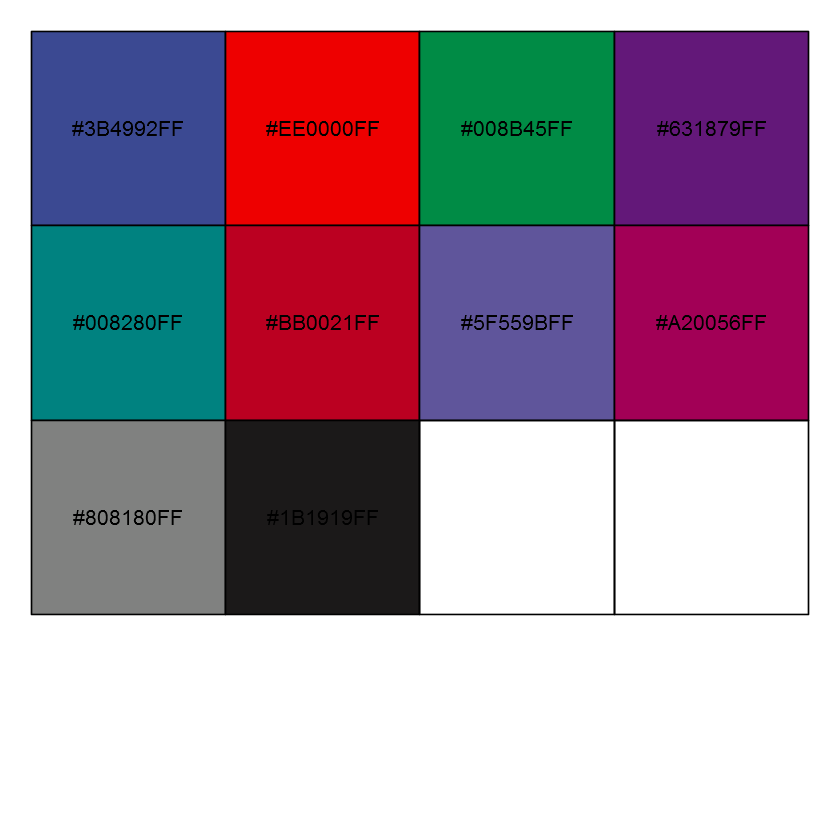

In [9]:
mypal = pal_aaas()(10)
mypal
show_col(mypal)

In [10]:
num_omics = data.frame(num_mrna = rep(0,length(alltissues)),stringsAsFactors = F,
                       tissues = alltissues,
                       tissue_systems = tissue.systems,
                      num_protein = rep(0,length(alltissues)),
                       num_met = rep(0,length(alltissues))
                       )
for(i in 1:length(alltissues)){
    num_omics$num_mrna[i] = nrow(mrna.tissues[[alltissues[i]]])
    num_omics$num_protein[i] = nrow(pro.tissues[[alltissues[i]]])
    num_omics$num_met[i] = nrow(met.tissues[[alltissues[i]]])
}
rownames(num_omics) = alltissues

In [11]:
idx = sort.int(num_omics$num_protein,decreasing = F,index.return = T)$ix
num_omics.v = num_omics[idx,]
idx = sort.int(num_omics.v$tissue_systems,decreasing = F,index.return = T)$ix
num_omics.v = num_omics.v[idx,]

# Figure S1 3 groups

## mRNA

In [305]:
#DEGage.gene
DEage.gene = list()
for(i in 1:nrow(num_omics.v)){
    tname = num_omics.v$tissues[i]
    tmp = mrna.tissues[[tname]]
    tmp.clin = mrna.tissues.info[[tname]]
      DEage.gene[[i]] = DEGenes.simplified(tmp,catagory = tmp.clin$stage == 4, 
                                           subset = tmp.clin$stage == 2 | tmp.clin$stage == 4)
}
names(DEage.gene) = num_omics.v$tissues

In [353]:
plot_blank <- function(tissuename){
    p = ggplot(,aes(x=c('Young','Elderly','Elderly_Treated'),y = c(-2, 0,  2))) +
    lghplot.addtheme(hjust = 1)+  
      xlab('')+ ylab('')+ theme(axis.text.x = element_text(size = 15,face = 'bold',color = "black"))+
      ggtitle(tissuename)+scale_color_aaas(alpha = 1)
    return(p)
}

plot_3group_overall <- function(M1,DEage.gene,metadata.tissue,tissuename, direction,is_x =1){
    tname = tissuename
    tmp = DEage.gene
    #M1 = mrna.tissues[[tname]]
    #metadata.tissue = mrna.tissues.info[[tname]]
    idx = metadata.tissue$stage == 2 | metadata.tissue$stage == 4 | metadata.tissue$stage == 5
    M1 = M1[,idx]
    metadata.tissue = metadata.tissue[idx,]
    cc = repmat(as.matrix(rowMedians(M1[,metadata.tissue$stage == '2'])),1,ncol(M1))
    tsd = repmat(as.matrix(apply(M1,1,sd,na.rm = T)),1,ncol(M1))
    M1.Z = (M1 - cc)/tsd
    
    
    if (tissuename == 'Arteria_cruralis'){
        tissuename = 'Femoral_artery'
    }
    
    if (direction == 'UP'){
         idgene1 = rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC > 0 & !is.na(tmp$Pvalue)]
         if(length(idgene1) < 2){
             p = plot_blank(tissuename)
             return(p)
             
         }
         M1.Z.v = M1.Z[idgene1,]
         M1.Z.v.mean = t(aggregate(t(M1.Z.v), by=list(metadata.tissue$stage), FUN=mean, na.rm = T))
         M1.Z.v.mean = M1.Z.v.mean[-1,]
    
   
        tmpdata1 = data.frame( expr = as.vector(M1.Z.v.mean),stringsAsFactors = F,
                      stage = rep(c(2,4,5),each = nrow(M1.Z.v.mean)),
                      group = factor(rep(c('Young','Elderly','Elderly_Treated'),each = nrow(M1.Z.v.mean)),
                                     level = c('Young','Elderly','Elderly_Treated')),
                     gene = rep(idgene1,times = ncol(M1.Z.v.mean))
                     )
        tpvalue1 = t.test(expr~stage, data = tmpdata1, subset = stage == 4 | stage == 5)$p.value
        vv1 = paste0('N = ',length(idgene1),'\n','p=',signif(tpvalue1,2))
      p = ggplot(tmpdata1,aes(x= group,y = expr,color = group)) +
        geom_line(aes(group = gene),color = 'gray87',alpha = 0.8 ,position = position_dodge(0.2))+
        geom_boxplot(width = 0.5,lwd = 0.6,outlier.color = NA,alpha = 0.2,)+scale_color_aaas()+
        lghplot.addtheme(hjust = 1)+
        geom_point(aes(fill = group,group = gene),alpha = 0.6,size = 1,position = position_dodge(0.2))+
        annotate(geom="text", x=2.5, y=0, 
               label = vv1, color="darkblue",size = 6)+ylab('')+xlab('')+ggtitle(tissuename)+
        scale_y_continuous(labels = scales::comma_format(accuracy =0.1))
    }else if(direction == 'DOWN'){
        
        idgene2 = rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC < 0 & !is.na(tmp$Pvalue)]
        if(length(idgene2) < 2){
             p = plot_blank(tissuename)
             return(p)
         }
        
        M1.Z.v1 = M1.Z[idgene2,]
        M1.Z.v1.mean = t(aggregate(t(M1.Z.v1), by=list(metadata.tissue$stage), FUN=mean, na.rm = T))
        M1.Z.v1.mean = M1.Z.v1.mean[-1,]
        
        tmpdata2 = data.frame( expr = as.vector(M1.Z.v1.mean),stringsAsFactors = F,
                      stage = rep(c(2,4,5),each = nrow(M1.Z.v1.mean)),
                      group = factor(rep(c('Young','Elderly','Elderly_Treated'),each = nrow(M1.Z.v1.mean)),
                                     level = c('Young','Elderly','Elderly_Treated')),
                     gene = rep(idgene2,times = ncol(M1.Z.v1.mean))
                     )
        tpvalue2 = t.test(expr~stage, data = tmpdata2, subset = stage == 4 | stage == 5)$p.value
       vv2 = paste0('N = ',length(idgene2),'\n','p=',signif(tpvalue2,2))
       p = ggplot(tmpdata2,aes(x= group,y = expr,color = group)) +
        geom_line(aes(group = gene),color = 'gray87',alpha = 0.8 ,position = position_dodge(0.2))+
        geom_boxplot(width = 0.5,lwd = 0.6,outlier.color = NA,alpha = 0.2,)+scale_color_aaas()+
        lghplot.addtheme(hjust = 1)+
        geom_point(aes(fill = group,group = gene),alpha = 0.6,size = 1,position = position_dodge(0.2))+
        annotate(geom="text", x=2.5, y=0, 
               label = vv2, color="darkblue",size = 6)+ylab('')+xlab('')+ggtitle(tissuename)+
        scale_y_continuous(labels = scales::comma_format(accuracy =0.1))
    }else{
        print('Direction should be UP or DOWN')
    }
    if (is_x == 0){
        p = p+ theme(axis.text.x=element_blank(),axis.title.x=element_blank())
    }
    return(p)
        
}


In [355]:
treatPlot.mrna.up = list()
for(i in 1:nrow(num_omics.v)){
     xi = num_omics.v$tissues[i]
      if (i < 21){
           treatPlot.mrna.up[[i]] = plot_3group_overall(mrna.tissues[[xi]],DEage.gene[[xi]],
                             mrna.tissues.info[[xi]],xi,'UP')
      }else{
          treatPlot.mrna.up[[i]] = plot_3group_overall(mrna.tissues[[xi]],DEage.gene[[xi]],
                             mrna.tissues.info[[xi]],xi,'UP',is_x = 1)
          
      }
}
names(treatPlot.mrna.up) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_mRNA_overall_3group_UP.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.mrna.up,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Z value of log2 CPM', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

In [356]:
treatPlot.mrna.down = list()
for(i in 1:nrow(num_omics.v)){
       xi = num_omics.v$tissues[i]
      if (i < 21){
          treatPlot.mrna.down[[i]] = plot_3group_overall(mrna.tissues[[xi]],DEage.gene[[xi]],
                             mrna.tissues.info[[xi]],xi,'DOWN')
    }else{
         treatPlot.mrna.down[[i]] = plot_3group_overall(mrna.tissues[[xi]],DEage.gene[[xi]],
                             mrna.tissues.info[[xi]],xi,'DOWN',is_x = 1)
          
      }
}
names(treatPlot.mrna.down) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_mRNA_overall_3group_DOWN.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.mrna.down,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Z value of log2 CPM', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

## protein

In [241]:
DEage.pro = list()
for(i in 1:nrow(num_omics.v)){
    tname = num_omics.v$tissues[i]
    tmp = pro.tissues[[tname]]
    tmp.clin = pro.tissues.info[[tname]]
      DEage.pro[[i]] = DEGenes.simplified(tmp,catagory = tmp.clin$stage == 4, 
                                           subset = tmp.clin$stage == 2 | tmp.clin$stage == 4)
}
names(DEage.pro) = num_omics.v$tissues

In [357]:
treatPlot.pro.up = list()
for(i in 1:nrow(num_omics.v)){
       xi = num_omics.v$tissues[i]
    if (i < 21){
       treatPlot.pro.up[[i]] = plot_3group_overall(pro.tissues[[xi]],DEage.pro[[xi]],
                             pro.tissues.info[[xi]],xi,'UP')
    }else{
        treatPlot.pro.up[[i]] = plot_3group_overall(pro.tissues[[xi]],DEage.pro[[xi]],
                             pro.tissues.info[[xi]],xi,'UP',is_x = 1)
    }
}
names(treatPlot.pro.up) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_pro_overall_3group_UP.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.pro.up,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'pro expression(log2 FPKM)',
                        left = textGrob('Z value of log2 protein abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

In [358]:
treatPlot.pro.down = list()
for(i in 1:nrow(num_omics.v)){
    xi = num_omics.v$tissues[i]
    if (i < 21){
      treatPlot.pro.down[[i]] = plot_3group_overall(pro.tissues[[xi]],DEage.pro[[xi]],
                             pro.tissues.info[[xi]],xi,'DOWN')
    }else{
      treatPlot.pro.down[[i]] = plot_3group_overall(pro.tissues[[xi]],DEage.pro[[xi]],
                             pro.tissues.info[[xi]],xi,'DOWN',is_x =1)
        
    }
}
names(treatPlot.pro.down) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_pro_overall_3group_DOWN.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.pro.down,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                        left = textGrob('Z value of log2 protein abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

## metabolites

In [274]:
DEage.met = list()
for(i in 1:nrow(num_omics.v)){
    tname = num_omics.v$tissues[i]
    tmp = met.tissues[[tname]]
    tmp.clin = met.tissues.info[[tname]]
      DEage.met[[i]] = DEGenes.simplified(tmp,catagory = tmp.clin$stage == 4, 
                                           subset = tmp.clin$stage == 2 | tmp.clin$stage == 4)
}
names(DEage.met) = num_omics.v$tissues

In [359]:
treatPlot.met.up = list()
for(i in 1:nrow(num_omics.v)){
       xi = num_omics.v$tissues[i]
      if (i < 21){
             treatPlot.met.up[[i]] = plot_3group_overall(met.tissues[[xi]],DEage.met[[xi]],
                             met.tissues.info[[xi]],xi,'UP')
        }else{
            treatPlot.met.up[[i]] = plot_3group_overall(met.tissues[[xi]],DEage.met[[xi]],
                             met.tissues.info[[xi]],xi,'UP',is_x  =1)  
      }
}
names(treatPlot.met.up) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_met_overall_3group_UP.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.met.up,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'met expression(log2 FPKM)',
                        left = textGrob('Z value of log2 metabolite abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

In [360]:
treatPlot.met.down = list()
for(i in 1:nrow(num_omics.v)){
       xi = num_omics.v$tissues[i]
      if (i < 21){
            treatPlot.met.down[[i]] = plot_3group_overall(met.tissues[[xi]],DEage.met[[xi]],
                             met.tissues.info[[xi]],xi,'DOWN')
      }else{
            treatPlot.met.down[[i]] = plot_3group_overall(met.tissues[[xi]],DEage.met[[xi]],
                             met.tissues.info[[xi]],xi,'DOWN',is_x = 1) 
      }
}
names(treatPlot.met.down) = num_omics.v$tissues

pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_met_overall_3group_DOWN.pdf",height = 13.8,width = 36)
grid.arrange(arrangeGrob(grobs = treatPlot.met.down,ncol = 10,heights = c(4.5,4.5,4.8),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                        left = textGrob('Z value of log2 metabolite abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

png 
  2

# Figure 5: reverse Aging related mols

## Aging related protein

In [293]:
plot_5group_overall <- function(M1,lmExpr.age,metadata.tissue,tissuename,is_x=0){
    agegene = rownames(M1)[lmExpr.age$p.age < 0.05]
    if (sum(metadata.tissue$stage == '1',na.rm = T) > 1){
        cc = repmat(as.matrix(rowMedians(M1[,metadata.tissue$stage == '1'])),1,ncol(M1))
    }else{
        cc = repmat(as.matrix(M1[,metadata.tissue$stage == '1'],na.rm = T),1,ncol(M1))
    }
    tsd = repmat(as.matrix(apply(M1,1,sd,na.rm = T)),1,ncol(M1))
    M1.Z = (M1 - cc)/tsd
    
    idgene1 = rownames(lmExpr.age)[lmExpr.age$p.age < 0.05 & lmExpr.age$beta.age > 0  & !is.na(lmExpr.age$p.age)]
    M1.Z.v = M1.Z[idgene1,]
    M1.Z.v.mean = t(aggregate(t(M1.Z.v), by=list(metadata.tissue$stage), FUN=mean, na.rm = T))
    M1.Z.v.mean = M1.Z.v.mean[-1,]
    
    idgene2 = rownames(lmExpr.age)[lmExpr.age$p.age < 0.05 & lmExpr.age$beta.age < 0  & !is.na(lmExpr.age$p.age)]
    M1.Z.v1 = M1.Z[idgene2,]
    M1.Z.v1.mean = t(aggregate(t(M1.Z.v1), by=list(metadata.tissue$stage), FUN=mean, na.rm = T))
    M1.Z.v1.mean = M1.Z.v1.mean[-1,]
    tmpdata1 = data.frame( expr = as.vector(M1.Z.v.mean),stringsAsFactors = F,
                      stage = rep(unique(metadata.tissue$stage),each = nrow(M1.Z.v.mean)),
                     gene = rep(idgene1,times = ncol(M1.Z.v.mean))
                     )
    tmpdata2 = data.frame( expr = as.vector(M1.Z.v1.mean),stringsAsFactors = F,
                      stage = rep(unique(metadata.tissue$stage),each = nrow(M1.Z.v1.mean)),
                     gene = rep(idgene2,times = ncol(M1.Z.v1.mean))
                     )
    
    tmpdata = rbind(tmpdata1,tmpdata2)
    tmpdata$direction = c(rep('UP',nrow(tmpdata1)),rep('DOWN',nrow(tmpdata2)))
    if(length(idgene1) < 2 | length(idgene2) < 2){
      p = ggplot(,aes(x=1:5,y = c(-1.5, -0.5, 0, 0.5,  1.5))) +theme_classic()+lghplot.addtheme(hjust = 1,size = 16)+  
      xlab('')+ ylab('')+ theme(axis.text.x = element_text(size = 15,face = 'bold',color = "black"))+
      scale_x_continuous(labels=c("1" = "Juvenile", "2" = "Young","3" = "Middle_aged",
                                  "4" = "Elderly","5" = "Elderly_Treated"))+
      
      scale_y_continuous(labels = scales::comma_format(accuracy =0.1)) +
      ggtitle(tissuename)+scale_color_aaas(alpha = 1)#+ ylim(-1.5,1.5)
      if (is_x == 0){
        p = p+ theme(axis.text.x=element_blank(),axis.title.x=element_blank())
       }
        return(p)
    }
    
    if (tissuename == 'Arteria_cruralis'){
        tissuename = 'Femoral_artery'
    }
    
    tpvalue1 = t.test(expr~stage, data = tmpdata1, subset = stage == '4' | stage == '5')$p.value
    tpvalue2 = t.test(expr~stage, data = tmpdata2, subset = stage == '4' | stage == '5')$p.value
    vv1 = paste0('N = ',length(idgene1),'\n','p=',signif(tpvalue1,2))
    vv2 = paste0('N = ',length(idgene2),'\n','p=',signif(tpvalue2,2))
    p = ggplot(tmpdata,aes(stage,expr,color = direction))+
      geom_smooth(method = 'loess',se = T,size = 1, alpha = 0.5)+ theme_classic()+lghplot.addtheme(hjust = 1,size = 16)+  
      xlab('')+ ylab('')+theme(axis.text.x = element_text(size = 15,face = 'bold',color = "black"))+
      scale_x_continuous(labels=c("1" = "Juvenile", "2" = "Young","3" = "Middle_aged",
                                  "4" = "Elderly","5" = "Elderly_Treated"))+
       annotate(geom="text", x=2, y=1.0, #fontface =2,#label=text,
               label = vv1, color="darkblue",size = 6)+
      scale_y_continuous(labels = scales::comma_format(accuracy =0.1)) +
     ggtitle(tissuename)+scale_color_aaas(alpha = 1)+ #ylim(-1.5,1.5)+
      annotate(geom="text", x=2, y=-1.0, #fontface =2,#label=text,
               label = vv2, color="darkblue",size = 6)
        
    if (is_x == 0){
        p = p+ theme(axis.text.x=element_blank(),axis.title.x=element_blank())
    }
    return(p)
}

In [13]:
lmExpr.age = list()
for(i in 1:length(pro.tissues)){
      lmExpr.age[[i]] = get_lmExpr(pro.tissues[[i]],pro.tissues.info[[i]])
}
names(lmExpr.age) = names(pro.tissues)
save(list = c('lmExpr.age'),file = './out/20220519_treatment/Aging_reverse/lmExpr.age_pro.Rdata')

Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison
Note: model has aliased coefficients
      sums of squares computed by model comparison


In [36]:
# write Data S1
load('./out/20220519_treatment/Aging_reverse/lmExpr.age_pro.Rdata')
DEtreat.pro = list()
outlist = list()
for(i in 1:length(pro.tissues)){
      DEtreat.pro[[i]] = get_DEexpr.treat(pro.tissues[[i]],pro.tissues.info[[i]])
      tmp = cbind(lmExpr.age[[i]],DEtreat.pro[[i]])
      tmp = tmp[,c('ID','meanExpr','beta.age','p.age','log2FC','Pvalue')]
      colnames(tmp) = c('ID','meanExpr.log2','beta.age','p.age','Treat_vs_elderly_log2FC','Treat_vs_elderly_Pvalue')
      idx = sort.int(tmp$p.age,decreasing = F,index.return = T)$ix
      tmp = tmp[idx,]
      tmp = tmp[tmp$p.age < 0.05,]
      outlist[[i]] = tmp
      
}
names(outlist) = names(pro.tissues)
names(DEtreat.pro) = names(pro.tissues)
#sort outlist
outlist.v = list()
for(i in 1:length(pro.tissues)){
    xi = num_omics.v$tissues[i]
    outlist.v[[i]] = outlist[[xi]]
}
names(outlist.v) = num_omics.v$tissues
openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Aging_reverse/Data S1_aging_treat_reverse_pro.xlsx")

In [295]:
agePlot = list()
for(i in 1:length(pro.tissues)){
    xi = num_omics.v$tissues[i]
    if (i < 21){
      agePlot[[i]] = plot_5group_overall(pro.tissues[[xi]],lmExpr.age[[xi]],
                             pro.tissues.info[[xi]],xi)
    }else{
      agePlot[[i]] = plot_5group_overall(pro.tissues[[xi]],lmExpr.age[[xi]],
                             pro.tissues.info[[xi]],xi,is_x = 1)
    }
    
}
names(agePlot) = num_omics.v$tissues

In [298]:
pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_protein_overall_v1.pdf",height = 12.6,width = 36)
grid.arrange(arrangeGrob(grobs = agePlot,ncol = 10,heights = c(3.5,3.5,4.6),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Z value of log2 protein abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth

png 
  2

## Aging related metabolites

In [53]:
lmExpr.met = list()
for(i in 1:length(met.tissues)){
      lmExpr.met[[i]] = get_lmExpr(met.tissues[[i]],met.tissues.info[[i]])
}
names(lmExpr.met) = names(met.tissues)
save(list = c('lmExpr.met'),file = './out/20220519_treatment/Aging_reverse/lmExpr.age_met.Rdata')

In [40]:
# write Data S2
load('./out/20220519_treatment/Aging_reverse/lmExpr.age_met.Rdata')
DEtreat.met = list()
outlist = list()
for(i in 1:length(met.tissues)){
      DEtreat.met[[i]] = get_DEexpr.treat(met.tissues[[i]],met.tissues.info[[i]])
      tmp = cbind(lmExpr.met[[i]],DEtreat.met[[i]])
      tmp = tmp[,c('ID','meanExpr','beta.age','p.age','log2FC','Pvalue')]
      colnames(tmp) = c('ID','meanExpr.log2','beta.age','p.age','Treat_vs_elderly_log2FC','Treat_vs_elderly_Pvalue')
      idx = sort.int(tmp$p.age,decreasing = F,index.return = T)$ix
      tmp = tmp[idx,]
      tmp = tmp[tmp$p.age < 0.05,]
      outlist[[i]] = tmp
      
}
names(outlist) = names(met.tissues)
names(DEtreat.met) = names(met.tissues)
#sort outlist
outlist.v = list()
for(i in 1:length(met.tissues)){
    xi = num_omics.v$tissues[i]
    outlist.v[[i]] = outlist[[xi]]
}
names(outlist.v) = num_omics.v$tissues
openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Aging_reverse/Data S2_aging_treat_reverse_met.xlsx")

In [301]:
agePlot.met = list()
for(i in 1:length(met.tissues)){
    xi = num_omics.v$tissues[i]
    if (i < 21){
      agePlot.met[[i]] = plot_5group_overall(met.tissues[[xi]],lmExpr.met[[xi]],
                             met.tissues.info[[xi]],xi)
    }else{
      agePlot.met[[i]] = plot_5group_overall(met.tissues[[xi]],lmExpr.met[[xi]],
                             met.tissues.info[[xi]],xi,is_x = 1)
    }
    
}
names(agePlot.met) = num_omics.v$tissues

In [302]:
graphics.off()
pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_met_overall_v1.pdf",height = 12.6,width = 36)
grid.arrange(arrangeGrob(grobs = agePlot.met,ncol = 10,heights = c(3.5,3.5,4.6),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Z value of log2 metabolite abundance', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth

null device 
          1

## Aging related transcripts

In [56]:
lmExpr.age.mrna = list()
for(i in 1:length(mrna.tissues)){
      lmExpr.age.mrna[[i]] = get_lmExpr(mrna.tissues[[i]],mrna.tissues.info[[i]])
}
names(lmExpr.age.mrna) = names(mrna.tissues)
save(list = c('lmExpr.age.mrna'),file = './out/20220519_treatment/Aging_reverse/lmExpr.age_mrna.Rdata')

In [48]:
# write Data S3
load('./out/20220519_treatment/Aging_reverse/lmExpr.age_mrna.Rdata')
DEtreat.mrna = list()
outlist = list()
for(i in 1:nrow(num_omics.v)){
      xx =num_omics.v$tissues[i]
      DEtreat.mrna[[i]] = get_DEexpr.treat(mrna.tissues[[xx]],mrna.tissues.info[[xx]])
      tmp = cbind(lmExpr.age.mrna[[xx]],DEtreat.mrna[[i]])
      tmp = tmp[,c('ID','meanExpr','beta.age','p.age','log2FC','Pvalue')]
      colnames(tmp) = c('ID','meanExpr.log2','beta.age','p.age','Treat_vs_elderly_log2FC','Treat_vs_elderly_Pvalue')
      idx = sort.int(tmp$p.age,decreasing = F,index.return = T)$ix
      tmp = tmp[idx,]
      tmp = tmp[tmp$p.age < 0.05,]
      outlist[[i]] = tmp
      
}
names(outlist) = num_omics.v$tissues
names(DEtreat.mrna) = num_omics.v$tissues
#sort outlist
outlist.v = list()
for(i in 1:nrow(num_omics.v)){
    xi = num_omics.v$tissues[i]
    outlist.v[[i]] = outlist[[xi]]
}
names(outlist.v) = num_omics.v$tissues
openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Aging_reverse/Data S3_aging_treat_reverse_mrna.xlsx")

In [303]:
agePlot.mrna = list()
for(i in 1:30){
    xx =num_omics.v$tissues[i]
    if (i < 21){
      agePlot.mrna[[i]] = plot_5group_overall(mrna.tissues[[xx]],lmExpr.age.mrna[[xx]],
                             mrna.tissues.info[[xx]],xx)
    }else{
      agePlot.mrna[[i]] = plot_5group_overall(mrna.tissues[[xx]],lmExpr.age.mrna[[xx]],
                             mrna.tissues.info[[xx]],xx,is_x = 1)
    }
    
}
names(agePlot.mrna) = num_omics.v$tissues

In [304]:
graphics.off()
pdf(file = "./out/20220519_treatment/Aging_reverse/plot_aging_reverse_mrna_overall_v1.pdf",height = 12.6,width = 36)
grid.arrange(arrangeGrob(grobs = agePlot.mrna,ncol =10,heights = c(3.5,3.5,4.6),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=25)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Z value of log2 CPM', gp=gpar(fontface="bold",  fontsize=25),rot=90)))
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth

null device 
          1

# Figure 6: trajactories rescue

## data construction

In [75]:
tissues = names(pro.tissues)
promet.tissues = list()
promet.tissues.info = list()
promet.tissues.Z = list()
mfuzz.promet.tissues = list()
promet.mstd.eset = list()
for(i in 1:length(tissues)){
#for(i in 1:1){
    tt = tissues[i]
    thispro = pro.tissues[[tt]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[tt]])
    thispro.header = pro.tissues.header[[tt]]
    thispro = thispro[rowSums(is.na(thispro)) < 1/3*ncol(thispro), ]
       #thispro = impute(delete_dup_genes_forprotein(thispro,thispro.header))
    thismet = met.tissues[[tt]]
       #idxx = which(is.element(rownames(thismet), rownames(thispro)))
       #rownames(thismet)[idxx] = paste0('met_',rownames(thismet)[idxx])
    rownames(thismet) = paste0('met_',rownames(thismet))
    thispromet = rbind2(thispro,thismet)
    #thispromet = thispro
    thisinfo = pro.tissues.info[[tt]]
    thisinfo = thisinfo[colnames(thispromet),]
    thispromet.median = t(aggregate(t(thispromet), by=list(thisinfo$stage), FUN=median, na.rm = T))
       #thispromet.median.eset = new("ExpressionSet",exprs = thispromet.median)
       #promet.norm.eset = filter.std(promet.norm.eset,min.std=0)
       #thispromet.median.eset.stand  =  standardise(thispromet.median.eset)
    mstd = standardise_matrix(thispromet.median)
    promet.tissues.Z[[i]] = mstd
    promet.tissues[[i]] = thispromet
    promet.tissues.info[[i]] = thisinfo
    mstd.v = mstd[rowSums(is.na(mstd))  == 0,]
    mstd.eset = new("ExpressionSet",exprs = mstd.v)
    promet.mstd.eset[[i]] = mstd.eset
    mfuzz.promet.tissues[[i]] = mfuzz(mstd.eset, c = 8,m = 1.5)

}
names(mfuzz.promet.tissues) = tissues
names(promet.tissues) = tissues
names(promet.tissues.Z) = tissues
names(promet.tissues.info) = tissues
names(promet.mstd.eset) = tissues

In [76]:
promet.tissues.mstd.eset = promet.mstd.eset

In [77]:
promet.tissues.Z.t = list()
for(i in 1:length(promet.tissues.Z)){
    tmp = as.data.frame(t(promet.tissues.Z[[i]]))
    promet.tissues.Z.t[[i]] = tmp
}
names(promet.tissues.Z.t) = names(promet.tissues.Z)

In [78]:
promet.whole.Z = t(as.matrix(as.data.frame(rbindlist(promet.tissues.Z.t,fill = T))))
colnames(promet.whole.Z) = paste0(rep(names(promet.tissues.Z),each = 5),'_',rep(1:5,times = 30))
promet.whole.Z.info = data.frame(tissue = rep(names(promet.tissues.Z),each = 5),stringsAsFactors = F,
                                stage = rep(1:5,times = 30))
rownames(promet.whole.Z.info) = colnames(promet.whole.Z)

## cluster trjactory change

In [79]:
mfuzz_aging = loadRData('./out/20210428_aging/promet/whole/promet_outdata.Rdata')

mfuzz.pro.aging = mfuzz_aging$mfuzz.promet.whole

In [80]:
promet.whole.Z.v = promet.whole.Z[rowSums(is.na(promet.whole.Z)) < 0.5*150,]
promet.whole.Z.mean = t(aggregate(t(promet.whole.Z.v), by=list(promet.whole.Z.info$stage), FUN=mean, na.rm = T))
promet.whole.Z.mean  =promet.whole.Z.mean[-1,]
promet.whole.Z.mean.v = promet.whole.Z.mean[rowSums(is.na(promet.whole.Z.mean))  == 0,]
promet.whole.Z.mean.eset = new("ExpressionSet",exprs = promet.whole.Z.mean.v)
dim(promet.whole.Z.mean.v)
sum(substr(rownames(promet.whole.Z.mean.v),1,4) == 'met_')

[1] 5332    5

[1] 1233

In [82]:
#
plot_overall_mfuzz <- function(promet.whole.Z.mean.v,mfuzz.pro.aging,tclass = 1){
  texpr = as.matrix(promet.whole.Z.mean.v)
  tgenes = names(mfuzz.pro.aging$cluster)[mfuzz.pro.aging$cluster == tclass]
  tgenes = intersect(tgenes,rownames(texpr))
  texpr = texpr[tgenes,]
  
  tmpdata = data.frame( expr = as.vector(texpr),stringsAsFactors = F,
                        stage = rep(1:5,each = nrow(texpr)),
                        gene = rep(tgenes,times = ncol(texpr))
  )
  tpvalue = t.test(expr~stage, data = tmpdata, subset = stage == '4' | stage == '5')$p.value
  vv = paste0('N = ',length(tgenes),'\n','p=',signif(tpvalue,2))
  p = ggplot(tmpdata,aes(stage,expr))+
    geom_smooth(method = 'loess',se = T,size = 1, alpha = 0.5,level = 0.99)+ theme_bw()+lghplot.addtheme(hjust = 1,size = 12)+  
    xlab('')+ ylab('')+
    scale_x_continuous(labels=c("1" = "Juvenile", "2" = "Young_adult","3" = "Middle_aged",
                                "4" = "Elderly","5" = "Elderly_Treated"))+
    annotate(geom="text", x=4, y=0.35, #fontface =2,#label=text,
             label = vv, color="darkblue",size = 5)+scale_color_aaas(alpha = 1)+
    ggtitle(paste0('Cluster ',tclass))+ylim(-0.5,0.5)
}
effectplot = list()
for(j in 1:8){
  effectplot[[j]] = plot_overall_mfuzz(promet.whole.Z.mean.v,mfuzz.pro.aging,tclass = j)
  
}

In [84]:
graphics.off()
pdf('./out/20220519_treatment/Trajactory_reverse/mfuzz_plot_8A_promet_based_on_aging_ggplot.pdf',width = 16,height = 8)
grid.arrange(arrangeGrob(grobs = effectplot,ncol = 4,
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=22)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                         left = textGrob('Z value of log2 protein abundance', gp=gpar(fontface="bold",  fontsize=22),rot=90)))
dev.off()

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


null device 
          1

## Correlation aging amplify and treatment amplify

In [85]:
the_centers = zeros(8,5)
for(i in 1:8){
  texpr = as.matrix(promet.whole.Z.mean.v)
  tgenes = names(mfuzz.pro.aging$cluster)[mfuzz.pro.aging$cluster == i]
  tgenes = intersect(tgenes,rownames(texpr))
  texpr = texpr[tgenes,]
  the_centers[i,] = apply(texpr,2,median,na.rm = T)
}
colnames(the_centers) = c(1:5)
the_centers

1,2,3,4,5
-0.27008573,-0.09494143,0.50444799,-0.06416551,-0.079232434
0.33669279,0.15111805,-0.35853931,-0.12765217,-0.008235044
-0.00398461,0.10467476,-0.36254993,0.15686126,0.082027056
0.15563744,0.18714505,0.02675107,-0.26873411,-0.094832793
0.10919094,-0.07623328,0.04657529,-0.03749237,-0.046481292
0.22508410,0.30076001,-0.98394420,0.18972903,0.158647385
0.07067816,-0.03731624,0.50233586,-0.36266671,-0.201648817
-0.35638302,-0.12456222,0.08025135,0.27844585,0.126283332


In [86]:
overall_effect = data.frame(amplitude = the_centers[,5]-the_centers[,4],
                       amplitude_aging = the_centers[,4]-the_centers[,1],
                     stringsAsFactors = F,
                     class = paste0('Cluster ',1:8))
overall_effect

amplitude,amplitude_aging,class
<dbl>,<dbl>,<chr>
-0.01506693,0.20592022,Cluster 1
0.11941713,-0.46434496,Cluster 2
-0.07483420,0.16084587,Cluster 3
0.17390131,-0.42437155,Cluster 4
-0.00898892,-0.14668331,Cluster 5
-0.03108165,-0.03535506,Cluster 6
0.16101789,-0.43334487,Cluster 7
-0.15216252,0.63482887,Cluster 8


In [87]:
tmpdata = data.frame(amplitude = the_centers[,5]-the_centers[,4],
                       amplitude_aging = the_centers[,4]-the_centers[,1],
                     stringsAsFactors = F,
                     class = paste0('Cluster ',1:8))
tmpdata
cor.test(tmpdata$amplitude,tmpdata$amplitude_aging)
vv = paste0('Rho = -0.935','\n','p = 0.0006')
pdf(file ='./out/20220519_treatment/Trajactory_reverse/treatment_cluster_amplitude_overall_aging vs treatment.pdf',width = 7,height = 5)
ggplot(tmpdata,aes(amplitude_aging,amplitude)) + geom_point(size = 4) + lghplot.addtheme(size = 18)+
   geom_smooth(method = 'lm',alpha = 0.15)+ xlab('Aging amplitude')+ ylab('MSC treatment amplitude')+
  geom_text_repel(aes(label = class),size = 7)+theme(axis.line = element_line(size = 1.2))+
     annotate(geom="text", x=0.25, y=0.15, fontface =2,#label=text,
             label = vv, color="darkblue",size = 7)
dev.off()

amplitude,amplitude_aging,class
<dbl>,<dbl>,<chr>
-0.01506693,0.20592022,Cluster 1
0.11941713,-0.46434496,Cluster 2
-0.07483420,0.16084587,Cluster 3
0.17390131,-0.42437155,Cluster 4
-0.00898892,-0.14668331,Cluster 5
-0.03108165,-0.03535506,Cluster 6
0.16101789,-0.43334487,Cluster 7
-0.15216252,0.63482887,Cluster 8



	Pearson's product-moment correlation

data:  tmpdata$amplitude and tmpdata$amplitude_aging
t = -6.4734, df = 6, p-value = 0.0006452
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9884795 -0.6764025
sample estimates:
       cor 
-0.9352808 


`geom_smooth()` using formula 'y ~ x'


png 
  2

## reverse aging in each tissue

In [88]:
tissues = names(promet.tissues.Z)
clusterdist = matrix(0,length(tissues),8)
clusteramplitude = matrix(0,length(tissues),8)
clusteramplitude_xx = matrix(0,length(tissues),8)
clusteramplitude_xx_aging = matrix(0,length(tissues),8)

for(i in 1:length(tissues)){
    mstd =   promet.tissues.Z[[i]] 
    for(j in 1:8){
    tgene = names(mfuzz.pro.aging$cluster)[mfuzz.pro.aging$cluster == j]
    tgene = intersect(tgene,rownames(mstd))
    bx = t(t(mstd[tgene,]) - mfuzz.pro.aging$centers[j,])
    clusterdist[i,j] = mean(sqrt(rowSums(bx^2)/(ncol(bx)-1)),na.rm = T)
    if(length(tgene) < 2){
      clusteramplitude[i,j] = NA
      next;
    }
    tamp = colMeans(mstd[tgene,],na.rm = T)
    clusteramplitude[i,j] = abs(tamp[5]-tamp[4])
    clusteramplitude_xx[i,j] = tamp[5]-tamp[4]
    clusteramplitude_xx_aging[i,j] = tamp[4]-tamp[1]
        
  }
}
rownames(clusteramplitude) = tissues
rownames(clusteramplitude_xx) = tissues
rownames(clusterdist) = tissues

In [89]:
for(j in 1:8){
  tmpdata = data.frame(amplitude = clusteramplitude_xx[,j],
                       amplitude_aging = clusteramplitude_xx_aging[,j],
                       stringsAsFactors = F,
                       variability = clusterdist[,j],
                       class = tissues,
                      tissue_system = tissue.systems[tissues])
     xmax = max(abs(tmpdata$amplitude_aging))+0.05
    ymax = max(abs(tmpdata$amplitude))+0.05
    p = ggplot(tmpdata,aes(amplitude_aging,amplitude,color = tissue_system)) + geom_point(size = 4) + lghplot.addtheme()+
    geom_hline(yintercept = 0,size = 1,alpha = 0.3)+
    geom_vline(xintercept = 0,size = 1,alpha = 0.3)+ 
    scale_color_aaas()+
    xlab('Aging amplitude')+ ylab('MSC treatment amplitude')+ ggtitle(paste0('Cluster ',j))+
    xlim(-xmax,xmax)+ylim(-ymax,ymax)+
    geom_text_repel(aes(label = class),size = 4,color = 1,box.padding = 0.5)+theme(axis.line = element_line(size = 1.2))
  pdf(paste0('./out/20220519_treatment/Trajactory_reverse/treatment_cluster_tissues_amplitude_aging vs treatment_V1_',j,'.pdf'),width = 6,height = 6)
  print(p)
  dev.off()
}

## Clustering BMSCs treatment

In [90]:
tmpaa = -sign(clusteramplitude_xx_aging)*clusteramplitude_xx
colnames(tmpaa) = paste0("C",1:8)
pheatmap::pheatmap(tmpaa[,c(2,4,7,8)],breaks = c(-0.6,-0.4,-0.2,-0.05,0.05,0.2,0.4,0.6),
                   cluster_cols = T,fontsize_row = 9,fontsize_col = 10,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = T,
                  color=colorRampPalette(c('#3B4992','gray99','#EE0000FF'))(8),
                   height = 7,width = 5,
                   file ="./out/20220519_treatment/Trajactory_reverse/treatment_heatmap_tissue_among_aging.pdf",
                  )


# Figure 7: Tissue DEchange and GO

In [35]:
sixtissues= c('Lung','Thymus','Ovary','Spleen','Kidney','Stomach')

## protein

In [91]:
DEpro.treat = list()
for(i in 1:length(pro.tissues)){
    tmpa = get_DEexpr.treat(pro.tissues[[i]],pro.tissues.info[[i]])
    tmpb = cbind(tmpa[,1],pro.tissues.header[[i]])
    DEpro.treat[[i]] =cbind(tmpb,tmpa[,-1])
    names(DEpro.treat[[i]])[1] = 'ID'
    outname = paste0('./out/20220519_treatment/Tissue_DEG/DEGout_pro/DEpro_treat_',names(pro.tissues)[i],'.txt')
    writetxt(DEpro.treat[[i]],outname)
}
names(DEpro.treat) = names(pro.tissues)

In [92]:
#write for Enrichment up
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEpro.treat)){
    tmp = DEpro.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC >0.58])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_pro/_inputGOenrich_treat_DEpro_up.txt',row.names = F,col.names = F)

In [93]:
#write for Enrichment down
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
for(i in 1:length(DEpro.treat)){
    tmp = DEpro.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC < -0.58])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_pro/_inputGOenrich_treat_DEpro_down.txt',row.names = F,col.names = F)

In [94]:
#write for Enrichment down
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
for(i in 1:length(DEpro.treat)){
    tmp = DEpro.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & abs(tmp$log2FC) > 0.58])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_pro/_inputGOenrich_treat_DEpro_all.txt',row.names = F,col.names = F)

In [36]:
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)

In [96]:
outids = c()
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(as.matrix(go1[,-1]))
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1.top10 = go1[idx1[1:10],]
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'_',rownames(go2))
go2 = as.matrix(go2[,-1])
idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2.top10 = go2[idx2[1:10],]
thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 0] = 1
thisgo.matrix[thisgo.matrix < 0] = -1
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

pheatmap::pheatmap(thisgo.matrix,cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEpro_eachtissue.pdf"
                   )

pheatmap::pheatmap(thisgo.matrix.top10,cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEpro_eachtissue_top10.pdf"
                   )

In [37]:
outids = c()
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(as.matrix(go1[,-1]))
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1.top10 = go1[idx1[1:10],]
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'_',rownames(go2))
go2 = as.matrix(go2[,-1])
idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2.top10 = go2[idx2[1:10],]
thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 0] = 1
thisgo.matrix[thisgo.matrix < 0] = -1
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

In [61]:
# 6tissues
outids = c()
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEpro/metascape_DEpro_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(as.matrix(go1[,-1]))
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1.top10 = go1[idx1[1:10],]
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'_',rownames(go2))
go2 = as.matrix(go2[,-1])
idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2.top10 = go2[idx2[1:10],]
thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 4] = 4
thisgo.matrix[thisgo.matrix < -4] = -4
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

ids = rowSums(abs(thisgo.matrix[,sixtissues]) > 2) > 1
pheatmap::pheatmap(thisgo.matrix[ids,sixtissues],cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(20),
                  height = 5,width = 5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEpro_eachtissue_6tissues.pdf"
                   )

In [58]:
ids = rowSums(abs(thisgo.matrix[,sixtissues]) > 2) > 1
thisgo.matrix[ids,sixtissues]

,Lung,Thymus,Ovary,Spleen,Kidney,Stomach
GO:1901361_organic cyclic compound catabolic process,2.109408,2.536527,2.026030,0.000000,0.000000,2.826122
GO:0007005_mitochondrion organization,0.000000,0.000000,2.014209,0.000000,0.000000,3.343585
R-HSA-9012999_RHO GTPase cycle,3.055308,0.000000,0.000000,0.000000,0.000000,2.178938
R-HSA-6798695_Neutrophil degranulation,0.000000,2.187234,0.000000,0.000000,0.000000,3.008581
R-HSA-72766_Translation,0.000000,0.000000,2.413784,0.000000,0.000000,4.000000
GO:0006412_translation,0.000000,0.000000,0.000000,2.377975,0.000000,4.000000
R-HSA-8953897_Cellular responses to stimuli,0.000000,0.000000,2.206369,0.000000,0.000000,4.000000
R-HSA-9675108_Nervous system development,0.000000,0.000000,2.975730,0.000000,0.000000,2.872975
R-HSA-8953854_Metabolism of RNA,0.000000,3.055479,0.000000,0.000000,0.000000,3.782873
GO:0090407_organophosphate biosynthetic process,2.559422,2.786755,3.822573,0.000000,0.000000,0.000000


In [57]:
sum(rowSums(abs(thisgo.matrix[,sixtissues]) > 2) > 1)

[1] 20

In [52]:
rownames(thisgo.matrix)

[1] "WP3888_VEGFA-VEGFR2 signaling pathway"                            
 [2] "GO:0097435_supramolecular fiber organization"                     
 [3] "R-HSA-5653656_Vesicle-mediated transport"                         
 [4] "GO:0022411_cellular component disassembly"                        
 [5] "GO:1901361_organic cyclic compound catabolic process"             
 [6] "GO:0007005_mitochondrion organization"                            
 [7] "GO:0016050_vesicle organization"                                  
 [8] "R-HSA-9012999_RHO GTPase cycle"                                   
 [9] "R-HSA-1474244_Extracellular matrix organization"                  
[10] "GO:0048193_Golgi vesicle transport"                               
[11] "GO:0010256_endomembrane system organization"                      
[12] "GO:0051668_localization within membrane"                          
[13] "R-HSA-6798695_Neutrophil degranulation"                           
[14] "R-HSA-72766_Translation"                                          
[15] "GO:0006412_translation"                                           
[16] "R-HSA-8953897_Cellular responses to stimuli"                      
[17] "R-HSA-9675108_Nervous system development"                         
[18] "R-HSA-8953854_Metabolism of RNA"                                  
[19] "GO:0090407_organophosphate biosynthetic process"                  
[20] "R-HSA-556833_Metabolism of lipids"                                
[21] "GO:0090407_organophosphate biosynthetic process"                  
[22] "R-HSA-556833_Metabolism of lipids"                                
[23] "R-HSA-5653656_Vesicle-mediated transport"                         
[24] "GO:0051668_localization within membrane"                          
[25] "R-HSA-9012999_RHO GTPase cycle"                                   
[26] "M5884_NABA CORE MATRISOME"                                        
[27] "R-HSA-6798695_Neutrophil degranulation"                           
[28] "R-HSA-9675108_Nervous system development"                         
[29] "GO:0003013_circulatory system process"                            
[30] "GO:0010035_response to inorganic substance"                       
[31] "R-HSA-109582_Hemostasis"                                          
[32] "GO:1901699_cellular response to nitrogen compound"                
[33] "GO:0030029_actin filament-based process"                          
[34] "GO:0051129_negative regulation of cellular component organization"
[35] "R-HSA-8953854_Metabolism of RNA"                                  
[36] "GO:0051235_maintenance of location"                               
[37] "GO:0007264_small GTPase mediated signal transduction"             
[38] "GO:0055086_nucleobase-containing small molecule metabolic process"
[39] "GO:0010256_endomembrane system organization"                      
[40] "R-HSA-1474244_Extracellular matrix organization"

In [48]:
rowSums(abs(thisgo.matrix))

WP3888_VEGFA-VEGFR2 signaling pathway 
                                                        28.313502 
                     GO:0097435_supramolecular fiber organization 
                                                        31.800769 
                         R-HSA-5653656_Vesicle-mediated transport 
                                                        29.711597 
                        GO:0022411_cellular component disassembly 
                                                         4.738448 
             GO:1901361_organic cyclic compound catabolic process 
                                                        17.871252 
                            GO:0007005_mitochondrion organization 
                                                        12.132701 
                                  GO:0016050_vesicle organization 
                                                         7.371648 
                                   R-HSA-9012999_RHO GTPase cycle 
                                                        19.560993 
                  R-HSA-1474244_Extracellular matrix organization 
                                                        17.071944 
                               GO:0048193_Golgi vesicle transport 
                                                        18.195578 
                      GO:0010256_endomembrane system organization 
                                                        13.075871 
                          GO:0051668_localization within membrane 
                                                        16.024326 
                           R-HSA-6798695_Neutrophil degranulation 
                                                        32.675620 
                                          R-HSA-72766_Translation 
                                                        24.275802 
                                           GO:0006412_translation 
                                                        24.653331 
                      R-HSA-8953897_Cellular responses to stimuli 
                                                        31.780034 
                         R-HSA-9675108_Nervous system development 
                                                        31.547020 
                                  R-HSA-8953854_Metabolism of RNA 
                                                        24.157408 
                  GO:0090407_organophosphate biosynthetic process 
                                                        24.555857 
                                R-HSA-556833_Metabolism of lipids 
                                                        30.985157 
                  GO:0090407_organophosphate biosynthetic process 
                                                        26.511186 
                                R-HSA-556833_Metabolism of lipids 
                                                        24.466289 
                         R-HSA-5653656_Vesicle-mediated transport 
                                                        32.283900 
                          GO:0051668_localization within membrane 
                                                        21.386740 
                                   R-HSA-9012999_RHO GTPase cycle 
                                                        12.160117 
                                        M5884_NABA CORE MATRISOME 
                                                        27.767168 
                           R-HSA-6798695_Neutrophil degranulation 
                                                        27.256462 
                         R-HSA-9675108_Nervous system development 
                                                        18.637215 
                            GO:0003013_circulatory system process 
                                                        24.021259 
                       GO:0010035_response to inorganic substance 
                                                        25.553055 
        

## mRNA

In [97]:
tissueNames = names(pro.tissues)

DEmrna.treat = list()
for(i in 1:length(tissueNames)){
    tname = tissueNames[i]
    tmpa = get_DEexpr.treat(mrna.tissues[[tname]],mrna.tissues.info[[tname]])
    #tmpb = cbind(tmpa[,1],mrna.tissues.header[[i]])
    DEmrna.treat[[i]] =tmpa
    #names(DEmrna.treat[[i]])[1] = 'ID'
    outname = paste0('./out/20220519_treatment/Tissue_DEG/DEGout_mRNA/DEmrna_treat_',tname,'.txt')
    writetxt(DEmrna.treat[[i]],outname)
}
names(DEmrna.treat) = tissueNames

In [98]:
#write for GOenrich down
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEmrna.treat)){
    tmp = DEmrna.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC < -0.58])
    tgenes = tgenes[!is.na(tgenes)]
    #tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_mRNA/_inputGOenrich_treat_DEmrna_down.txt',row.names = F,col.names = F)

In [99]:
#write for GOenrich up
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEmrna.treat)){
    tmp = DEmrna.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC > 0.58])
    tgenes = tgenes[!is.na(tgenes)]
    #tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_mRNA/_inputGOenrich_treat_DEmrna_up.txt',row.names = F,col.names = F)

In [100]:
#write for GOenrich all
inputGOenrich = data.frame(tissues = names(pro.tissues),stringsAsFactors = F,
                      genes = rep('c',length(pro.tissues)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEmrna.treat)){
    tmp = DEmrna.treat[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & abs(tmp$log2FC) > 0.58])
    tgenes = tgenes[!is.na(tgenes)]
    #tgenes = unique(pro.tissues.header[[i]][tgenes,]$Gene)
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20220519_treatment/Tissue_DEG/DEGout_mRNA/_inputGOenrich_treat_DEmrna_all.txt',row.names = F,col.names = F)

In [101]:
outids = c()
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEmrna/metascape_DEmrna_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEmrna/metascape_DEmrna_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(as.matrix(go1[,-1]))
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1.top10 = go1[idx1[1:10],]
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'_',rownames(go2))
go2 = as.matrix(go2[,-1])
idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2.top10 = go2[idx2[1:10],]
thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 0] = 1
thisgo.matrix[thisgo.matrix < 0] = -1
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

pheatmap::pheatmap(thisgo.matrix,cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEmrna_eachtissue.pdf"
                   )

pheatmap::pheatmap(thisgo.matrix.top10,cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEmrna_eachtissue_top10.pdf"
                   )

In [65]:
# 6tissues
outids = c()
tpath1 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEmrna/metascape_DEmrna_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = 'E:/github/code_forpublication/macaca_multiple_tissue/figures_treatment/Figure_DEanalysis_data/DEmrna/metascape_DEmrna_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(as.matrix(go1[,-1]))
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1.top10 = go1[idx1[1:10],]
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'_',rownames(go2))
go2 = as.matrix(go2[,-1])
idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2.top10 = go2[idx2[1:10],]
thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 4] = 4
thisgo.matrix[thisgo.matrix < -4] = -4
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

ids = rowSums(abs(thisgo.matrix[,sixtissues]) > 2) > 1
pheatmap::pheatmap(thisgo.matrix[ids,sixtissues],cluster_rows = T,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(20),
                  height = 6,width = 5.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_metascape_DEmrna_eachtissue_6tissues.pdf"
                   )

## metabolite

In [103]:
tissueNames = names(pro.tissues)

DEmet.treat = list()
for(i in 1:length(tissueNames)){
    tname = tissueNames[i]
    tmpa = get_DEexpr.treat(met.tissues[[tname]],met.tissues.info[[tname]])
    #tmpb = cbind(tmpa[,1],met.tissues.header[[i]])
    DEmet.treat[[i]] =tmpa
    #names(DEmet.treat[[i]])[1] = 'ID'
    outname = paste0('./out/20220519_treatment/Tissue_DEG/DEGout_met/DEmet_treat_',tname,'.txt')
    writetxt(DEmet.treat[[i]],outname)
}
names(DEmet.treat) = tissueNames

In [104]:
# enrichment
met.class_enrichment <- function(mets,annote){
  require(clusterProfiler)

  vmet = intersect(mets,rownames(annote))
  fluxgmt = data.frame(ont = annote$sub_class,gene = rownames(annote),stringsAsFactors = F) 
 #   fluxgmt = data.frame(ont = annote$class,gene = rownames(annote),stringsAsFactors = F) 
  
  Recon3D <- enricher(gene = vmet,
                TERM2GENE=fluxgmt,
                pAdjustMethod = "BH",
                minGSSize = 1,
                pvalueCutoff =1,
                qvalueCutoff = 1
                )
  Recon3Dout = Recon3D@result
  Recon3Dout$DB = rep('HMDBclass',dim(Recon3Dout)[1])
  n = dim(Recon3Dout)[2]
  Recon3Dout = Recon3Dout[,c(n,1:(n-1))]
  return(Recon3Dout)
}

In [105]:
metenrich.up = matrix(1,100,length(DEmet.treat))
rownames(metenrich.up)  = paste('X',1:nrow(metenrich.up))
k = 0
met.header.all.hmdb.v1 = met.header.all.hmdb.v
rownames(met.header.all.hmdb.v1) = paste0('met_',rownames(met.header.all.hmdb.v1))
for(i in 1:length(DEmet.treat)){
    tmpDEmet = DEmet.treat[[i]]
    
    tgene = rownames(tmpDEmet)[tmpDEmet$Pvalue < 0.05 & tmpDEmet$log2FC > 0]
    tgene = paste0('met_',tgene)
    tgene = intersect(tgene,rownames(met.header.all.hmdb.v1))
    tmp = met.class_enrichment(tgene,met.header.all.hmdb.v1)
    tmp = tmp[tmp$p.adjust < 1e-2,]
    if(nrow(tmp) < 1) next;
    for(j in 1:nrow(tmp)){
        thisname = rownames(tmp)[j]
        if(sum(rownames(metenrich.up) == thisname) > 0){
            metenrich.up[thisname,i] = tmp$p.adjust[j]
        }else{
            k = k+1;
            metenrich.up[k,i] = tmp$p.adjust[j]
            rownames(metenrich.up)[k] = thisname
        }
    }  
}
metenrich.up = log10(metenrich.up[1:k,])
colnames(metenrich.up) = names(DEmet.treat)

Loading required package: clusterProfiler

Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.12.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


In [106]:
metenrich.down = matrix(1,100,length(DEmet.treat))
rownames(metenrich.down)  = paste('X',1:nrow(metenrich.down))
k = 0
met.header.all.hmdb.v1 = met.header.all.hmdb.v
rownames(met.header.all.hmdb.v1) = paste0('met_',rownames(met.header.all.hmdb.v1))
for(i in 1:length(DEmet.treat)){
    tmpDEmet = DEmet.treat[[i]]
    
    tgene = rownames(tmpDEmet)[tmpDEmet$Pvalue < 0.05 & tmpDEmet$log2FC < 0]
    tgene = paste0('met_',tgene)
    tgene = intersect(tgene,rownames(met.header.all.hmdb.v1))
    if (length(tgene) <2) next;
    tmp = met.class_enrichment(tgene,met.header.all.hmdb.v1)
    tmp = tmp[tmp$p.adjust < 1e-2,]
    if(nrow(tmp) < 1) next;
    for(j in 1:nrow(tmp)){
        thisname = rownames(tmp)[j]
        if(sum(rownames(metenrich.down) == thisname) > 0){
            metenrich.down[thisname,i] = tmp$p.adjust[j]
        }else{
            k = k+1;
            metenrich.down[k,i] = tmp$p.adjust[j]
            rownames(metenrich.down)[k] = thisname
        }
    }  
}
metenrich.down = log10(metenrich.down[1:k,])
colnames(metenrich.down) = names(DEmet.treat)

In [107]:
go1 = metenrich.up
go2 = metenrich.down
#rownames(go1) = paste0(go1$GO,'_',rownames(go1))
go1 = abs(go1)
idx1 = sort.int(rowSums(go1 >0),decreasing = T,index.return = T)$ix
go1 = go1[idx1,]
go1.top10 = go1[1:10,]

idx2 = sort.int(rowSums(abs(go2) >0),decreasing = T,index.return = T)$ix
go2 = go2[idx2,]
go2.top10 = go2[1:10,]

thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
thisgo.matrix[abs(thisgo.matrix) < 2] = 0
thisgo.matrix[thisgo.matrix > 0] = 1
thisgo.matrix[thisgo.matrix < 0] = -1
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))

thisgo.top10 = rbind(go1.top10,go2.top10)
thisgo.matrix.top10 = as.matrix(thisgo.top10)
thisgo.matrix.top10[abs(thisgo.matrix.top10) < 2] = 0
thisgo.matrix.top10[thisgo.matrix.top10 > 0] = 1
thisgo.matrix.top10[thisgo.matrix.top10 < 0] = -1
colnames(thisgo.matrix.top10) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix.top10)))

pheatmap::pheatmap(thisgo.matrix,cluster_rows = F,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                  file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_clusterprofile_DEmet_eachtissue.pdf"
                   )

pheatmap::pheatmap(thisgo.matrix.top10,cluster_rows = F,cluster_cols = T,fontsize_row = 8,fontsize_col = 8,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021FF'))(3),
                  height = 10,width = 8.5,
                 file ="./out/20220519_treatment/Tissue_DEG/Figure_DEanalysis_heatmap_GOenrichment_clusterprofile_DEmet_eachtissue_top10.pdf"
                   )

# Figure 8: Common DEchange and GO

## protein

In [13]:
DEproFC = list()
DEproPvalue = list()
DEtreat.pro = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thispro = pro.tissues[[thistissue]]
    thispro.header = pro.tissues.header[[thistissue]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[thistissue]])
    thispro.info = pro.tissues.info[[thistissue]]
    thisDEpro = DEGenes.simplified(thispro,catagory = thispro.info$stage == 5,
                               subset = thispro.info$stage == 4 | thispro.info$stage == 5)
    DEtreat.pro[[i]] = thisDEpro
    DEproFC[[i]] = thisDEpro$log2FC
    names(DEproFC[[i]]) = rownames(thisDEpro)
    DEproPvalue[[i]] = thisDEpro$Pvalue
    names(DEproPvalue[[i]])  = rownames(thisDEpro)
}
names(DEproFC) = alltissues
names(DEproPvalue) = alltissues
names(DEtreat.pro) = alltissues

In [14]:
#write DEtreat pro
#sort outlist
outlist.v = list()
for(i in 1:length(alltissues)){
    xi = num_omics.v$tissues[i]
    tmp = DEtreat.pro[[xi]]
    tmp = tmp[!is.na(tmp$Pvalue),]
    idx  =sort.int(tmp$Pvalue,decreasing = F,index.return = T)$ix
    tmp = tmp[idx,]
    tmp = tmp[tmp$Pvalue < 0.05,-5]
    outlist.v[[i]] = tmp
}
names(outlist.v) = num_omics.v$tissues
#openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Tissue_DEG/Data S5_DEG_treatment_pro.xlsx")

In [15]:
list_to_matrix <- function(DEproFC,alltissues){
    DEproFC_matrix = list()
    for(i in 1:length(alltissues)){
        tmp = matrix(DEproFC[[i]],1,length(DEproFC[[i]]))
        tmp = as.data.frame(tmp)
        colnames(tmp) = names(DEproFC[[i]])
        DEproFC_matrix[[i]] = tmp
    }
    DEproFC_matrix = t(as.matrix(rbindlist(DEproFC_matrix,fill = T)))
    colnames(DEproFC_matrix) = names(DEproFC)
    #vid = rowSums(is.na(DEproFC_matrix)) < ncol(DEproFC_matrix)/2
    #DEproFC_matrix = DEproFC_matrix[vid,]
    return(DEproFC_matrix)
}
DEproFC_matrix = list_to_matrix(DEproFC,alltissues)
DEproPvalue_matrix = list_to_matrix(DEproPvalue,alltissues)


In [63]:
MSC_pro_sigup_matrix = (DEproFC_matrix > 0.58 & DEproPvalue_matrix < 0.05) +0
MSC_pro_sigdown_matrix = -((DEproFC_matrix < -0.58 & DEproPvalue_matrix < 0.05) +0)
MSC_pro_sigall_matrix = MSC_pro_sigup_matrix + MSC_pro_sigdown_matrix

MSC_pro_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_pro_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_pro_sigup_matrix)),
                              num.down = colSums(MSC_pro_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_pro_sigdown_matrix)),
                              num.all = colSums(abs(MSC_pro_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_pro_sigall_matrix)),
                             tissues = colnames(MSC_pro_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_pro_updown) = MSC_pro_updown$tissues

upgenes = rownames(MSC_pro_sigall_matrix)[rowSums(MSC_pro_sigall_matrix > 0,na.rm = T) > 1]
downgenes = rownames(MSC_pro_sigall_matrix)[rowSums(MSC_pro_sigall_matrix < 0,na.rm = T) > 1]
length(upgenes)
length(downgenes)
writetxt(upgenes,filename = './out/20220519_treatment/Common_DEG/pro_common_up.txt',col.names = F)
writetxt(downgenes,filename = './out/20220519_treatment/Common_DEG/pro_common_down.txt',col.names = F)


[1] 474

[1] 375

In [81]:
mean(MSC_pro_updown$num.all)

[1] 0.03769285

## mRNA


In [66]:
DEmrnaFC = list()
DEmrnaPvalue = list()
DEtreat.mrna = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismrna = mrna.tissues[[thistissue]]
    #thismrna.header = mrna.tissues.header[[thistissue]]
    thismrna.info = mrna.tissues.info[[thistissue]]
    if (sum(thismrna.info$stage == 1) ==1){ 
        thismrna = cbind(thismrna[,thismrna.info$stage == 1],thismrna)
        thismrna.info = rbind(thismrna.info[thismrna.info$stage == 1,],thismrna.info)
    }
    if (sum(thismrna.info$stage == 4) ==1){ 
        thismrna = cbind(thismrna,thismrna[,thismrna.info$stage == 4])
        thismrna.info = rbind(thismrna.info,thismrna.info[thismrna.info$stage == 4,])
    }
    
    thisDEmrna = DEGenes.simplified(thismrna,catagory = thismrna.info$stage == 5,
                               subset = thismrna.info$stage == 4 | thismrna.info$stage == 5)
    DEtreat.mrna[[i]] = thisDEmrna
    DEmrnaFC[[i]] = thisDEmrna$log2FC
    names(DEmrnaFC[[i]]) = rownames(thisDEmrna)
    DEmrnaPvalue[[i]] = thisDEmrna$Pvalue
    names(DEmrnaPvalue[[i]])  = rownames(thisDEmrna)
}
names(DEmrnaFC) = alltissues
names(DEmrnaPvalue) = alltissues
names(DEtreat.mrna) = alltissues
DEmrnaFC_matrix = list_to_matrix(DEmrnaFC,alltissues)
DEmrnaPvalue_matrix = list_to_matrix(DEmrnaPvalue,alltissues)

In [75]:
#write DEtreat mrna
#sort outlist
outlist.v = list()
for(i in 1:length(alltissues)){
    xi = num_omics.v$tissues[i]
    tmp = DEtreat.mrna[[xi]]
    tmp = tmp[!is.na(tmp$Pvalue),]
    idx  =sort.int(tmp$Pvalue,decreasing = F,index.return = T)$ix
    tmp = tmp[idx,]
    tmp = tmp[tmp$Pvalue < 0.05,-5]
    outlist.v[[i]] = tmp
}
names(outlist.v) = num_omics.v$tissues
openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Tissue_DEG/Data S4_DEG_treatment_mrna.xlsx")

In [69]:
MSC_mrna_sigup_matrix = (DEmrnaFC_matrix > 0.58 & DEmrnaPvalue_matrix < 0.05) +0
MSC_mrna_sigdown_matrix = -((DEmrnaFC_matrix < -0.58 & DEmrnaPvalue_matrix < 0.05) +0)
MSC_mrna_sigall_matrix = MSC_mrna_sigup_matrix + MSC_mrna_sigdown_matrix

MSC_mrna_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_mrna_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_mrna_sigup_matrix)),
                              num.down = colSums(MSC_mrna_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_mrna_sigdown_matrix)),
                              num.all = colSums(abs(MSC_mrna_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_mrna_sigall_matrix)),
                             tissues = colnames(MSC_mrna_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_mrna_updown) = MSC_mrna_updown$tissues

upgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix > 0,na.rm = T) > 1]
downgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix < 0,na.rm = T) > 1]
length(upgenes.mrna)
length(downgenes.mrna)

writetxt(upgenes.mrna,filename = './out/20220519_treatment/Common_DEG/mRNA_common_up.txt',col.names = F)
writetxt(downgenes.mrna,filename = './out/20220519_treatment/Common_DEG/mRNA_common_down.txt',col.names = F)

[1] 1566

[1] 1291

In [82]:
mean(MSC_mrna_updown$num.all)

[1] 0.03650501

## metabolism

In [70]:
DEmetFC = list()
DEmetPvalue = list()
DEtreat.met = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismet = met.tissues[[thistissue]]
    thismet.header = met.tissues.header[[thistissue]]
    thismet.info = met.tissues.info[[thistissue]]
    if (sum(thismet.info$stage == 1) ==1){ 
        thismet = cbind(thismet[,thismet.info$stage == 1],thismet)
        thismet.info = rbind(thismet.info[thismet.info$stage == 1,],thismet.info)
    }
    if (sum(thismet.info$stage == 4) ==1){ 
        thismet = cbind(thismet,thismet[,thismet.info$stage == 4])
        thismet.info = rbind(thismet.info,thismet.info[thismet.info$stage == 4,])
    }
    
    thisDEmet = DEGenes.simplified(thismet,catagory = thismet.info$stage == 5,
                               subset = thismet.info$stage == 5 | thismet.info$stage == 4)
    DEtreat.met[[i]] = thisDEmet
    DEmetFC[[i]] = thisDEmet$log2FC
    names(DEmetFC[[i]]) = rownames(thisDEmet)
    DEmetPvalue[[i]] = thisDEmet$Pvalue
    names(DEmetPvalue[[i]])  = rownames(thisDEmet)
}
names(DEmetFC) = alltissues
names(DEmetPvalue) = alltissues
names(DEtreat.met) = alltissues
DEmetFC_matrix = list_to_matrix(DEmetFC,alltissues)
DEmetPvalue_matrix = list_to_matrix(DEmetPvalue,alltissues)

In [76]:
#write DEtreat mrna
#sort outlist
outlist.v = list()
for(i in 1:length(alltissues)){
    xi = num_omics.v$tissues[i]
    tmp = DEtreat.met[[xi]]
    tmp = tmp[!is.na(tmp$Pvalue),]
    idx  =sort.int(tmp$Pvalue,decreasing = F,index.return = T)$ix
    tmp = tmp[idx,]
    tmp = tmp[tmp$Pvalue < 0.05,-5]
    outlist.v[[i]] = tmp
}
names(outlist.v) = num_omics.v$tissues
openxlsx::write.xlsx(outlist.v, file = "./out/20220519_treatment/Tissue_DEG/Data S6_DEG_treatment_met.xlsx")

In [71]:
MSC_met_sigup_matrix = (DEmetFC_matrix > 0.58 & DEmetPvalue_matrix < 0.05) +0
MSC_met_sigdown_matrix = -((DEmetFC_matrix < -0.58 & DEmetPvalue_matrix < 0.05) +0)
MSC_met_sigall_matrix = MSC_met_sigup_matrix + MSC_met_sigdown_matrix

MSC_met_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_met_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_met_sigup_matrix)),
                              num.down = colSums(MSC_met_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_met_sigdown_matrix)),
                              num.all = colSums(abs(MSC_met_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_met_sigall_matrix)),
                             tissues = colnames(MSC_met_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_met_updown) = MSC_met_updown$tissues

upmets = rownames(MSC_met_sigall_matrix)[rowSums(MSC_met_sigall_matrix > 0,na.rm = T) > 1]
length(upmets)
downmets = rownames(MSC_met_sigall_matrix)[rowSums(MSC_met_sigall_matrix < 0,na.rm = T) > 1]
length(downmets)

writetxt(upmets,filename = './out/20220519_treatment/Common_DEG/met_common_up.txt',col.names = F)
writetxt(downmets,filename = './out/20220519_treatment/Common_DEG/met_common_down.txt',col.names = F)

[1] 152

[1] 179

In [83]:
mean(MSC_met_updown$num.all)

[1] 0.04576727

## Figure #overall change after treatment

In [79]:
MSC_pro_updown.v

,num.up,num.down,num.all,tissues,tissue_systems
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Hypothalamus,0.009026435,-0.011605416,0.02063185,Hypothalamus,Brain
Supramarginal_gyrus,0.011648601,-0.009060023,0.02070862,Supramarginal_gyrus,Brain
Hippocampus,0.017099863,-0.004787962,0.02188782,Hippocampus,Brain
Frontal_pole,0.009405388,-0.016260163,0.02566555,Frontal_pole,Brain
Superior_temporal_gyrus,0.016382481,-0.009695754,0.02607823,Superior_temporal_gyrus,Brain
Aortic_arch,0.018601919,-0.012336009,0.03093793,Aortic_arch,Cardiovascular
Arteria_carotis,0.010863125,-0.027849101,0.03871223,Arteria_carotis,Cardiovascular
Femoral_vein,0.032940546,-0.011783610,0.04472416,Femoral_vein,Cardiovascular
Arteria_cruralis,0.027720207,-0.027202073,0.05492228,Arteria_cruralis,Cardiovascular


In [77]:
plotMSCNum = list()
idx = sort.int(MSC_pro_updown$num.all,decreasing = F,index.return = T)$ix
MSC_pro_updown.v = MSC_pro_updown[idx,]
idx = sort.int(MSC_pro_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
MSC_pro_updown.v = MSC_pro_updown.v[idx,]
tissueindex = rownames(MSC_pro_updown.v)
MSC_met_updown.v = MSC_met_updown[tissueindex,]

p1 = ggplot(MSC_met_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotMSCNum[[1]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),axis.line.x =element_blank())+
scale_y_continuous(labels = fmt_dcimals(2))+
ylab('Metabolites')+ xlab('')#+ylim(0,8200)


#idx = sort.int(MSC_pro_updown$num.all,decreasing = F,index.return = T)$ix
#MSC_pro_updown.v = MSC_pro_updown[idx,]
#idx = sort.int(MSC_pro_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
MSC_pro_updown.v = MSC_pro_updown[tissueindex,]

p1 = ggplot(MSC_pro_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotMSCNum[[2]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+  theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),axis.line.x =element_blank())+scale_y_continuous(labels = fmt_dcimals(2))+
ylab('Proteins')+ xlab('')#+ylim(0,8200)+scale_y_log10

#idx = sort.int(MSC_mrna_updown$num.all,decreasing = F,index.return = T)$ix
#MSC_mrna_updown.v = MSC_mrna_updown[idx,]
#idx = sort.int(MSC_mrna_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
MSC_mrna_updown.v = MSC_mrna_updown[tissueindex,]

p1 = ggplot(MSC_mrna_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotMSCNum[[3]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+scale_y_continuous(labels = fmt_dcimals(2))+
ylab('mRNAs')+ xlab('')#+ylim(0,8200)

In [124]:
pdf(file = './out/20220519_treatment/Tissue_DEG/MSCplot_DEnumber_barplot.pdf',width = 12,height = 9)
grid.arrange(arrangeGrob(grobs = plotMSCNum,ncol = 1,heights = c(2.4,2.4,4.2)))
dev.off()

png 
  2

## top 15

In [125]:
tmpid = sort.int(rowSums(MSC_mrna_sigall_matrix,na.rm = T),decreasing = T,index.return = T)$ix
top20up = rownames(MSC_mrna_sigall_matrix)[tmpid[1:15]]
tmpid = sort.int(rowSums(MSC_mrna_sigall_matrix,na.rm = T),decreasing = F,index.return = T)$ix
top20down = rownames(MSC_mrna_sigall_matrix)[tmpid[1:15]]
xx = MSC_mrna_sigall_matrix[c(top20up,top20down),]
xx[is.na(xx)] = 0
#pdf(file ="./Figures/v20210402/figure2/Figure2B_commome_mRNAA.pdf",height = 4,width = 3)

pheatmap::pheatmap(xx,cluster_rows = T,fontsize_row = 8,fontsize_col = 8,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(6),
                  file ="./out/20220519_treatment/Common_DEG/MSCplot_commome_mRNA_top15.pdf",
                  ,height = 5,width = 4.6)

In [73]:
tmpid = sort.int(rowSums(MSC_mrna_sigall_matrix[,sixtissues],na.rm = T),decreasing = T,index.return = T)$ix
top20up = rownames(MSC_mrna_sigall_matrix[,sixtissues])[tmpid[1:10]]
tmpid = sort.int(rowSums(MSC_mrna_sigall_matrix[,sixtissues],na.rm = T),decreasing = F,index.return = T)$ix
top20down = rownames(MSC_mrna_sigall_matrix[,sixtissues])[tmpid[1:10]]
xx = MSC_mrna_sigall_matrix[c(top20up,top20down),sixtissues]
xx[is.na(xx)] = 0
#pdf(file ="./Figures/v20210402/figure2/Figure2B_commome_mRNAA.pdf",height = 4,width = 3)

pheatmap::pheatmap(xx,cluster_rows = T,fontsize_row = 8,fontsize_col = 8,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(6),
                  file ="./out/20220519_treatment/Common_DEG/MSCplot_commome_mRNA_top15_6tissues.pdf",
                  ,height = 4,width = 3)

In [75]:
tmpid = sort.int(rowSums(MSC_pro_sigall_matrix[,sixtissues],na.rm = T),decreasing = T,index.return = T)$ix
top20up = rownames(MSC_pro_sigall_matrix[,sixtissues])[tmpid[1:10]]
tmpid = sort.int(rowSums(MSC_pro_sigall_matrix[,sixtissues],na.rm = T),decreasing = F,index.return = T)$ix
top20down = rownames(MSC_pro_sigall_matrix[,sixtissues])[tmpid[1:10]]
xx = MSC_pro_sigall_matrix[c(top20up,top20down),sixtissues]
xx[is.na(xx)] = 0
#pdf(file ="./Figures/v20210402/figure2/Figure2B_commome_proA.pdf",height = 4,width = 3)

pheatmap::pheatmap(xx,cluster_rows = T,fontsize_row = 9,fontsize_col = 9,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(6),
                  file ="./out/20220519_treatment/Common_DEG/MSCplot_commome_pro_top15_6tissues.pdf",
                  ,height = 4,width = 3)

In [21]:
graphics.off()

In [26]:
tmpid = sort.int(rowSums(MSC_met_sigall_matrix,na.rm = T),decreasing = T,index.return = T)$ix
top20up = rownames(MSC_met_sigall_matrix)[tmpid[1:15]]
tmpid = sort.int(rowSums(MSC_met_sigall_matrix,na.rm = T),decreasing = F,index.return = T)$ix
top20down = rownames(MSC_met_sigall_matrix)[tmpid[1:15]]
xx = MSC_met_sigall_matrix[c(top20up,top20down),]
#xx[is.na(xx)] = 0
aa = c('6-(3-hydroxybutan-2-yl)-5-(hydroxymethyl)-4-methoxy-2H-pyran-2-one',
       '2-[4-(tert-butyl)-2,3-dihydro-1,3-thiazol-2-yliden]-3-oxobutanenitrile',
       '2-hydroxy-6-[(8Z,11Z)-pentadeca-8,11,14-trien-1-yl]benzoic acid',
       '2-(2-amino-3-methylbutanamido)-3-phenylpropanoic acid',
       '3-(methylsulfonyl)-2H-chromen-2-one',
       'N-[2-chloro-6-(trifluoromethoxy)phenyl]-2,2-dimethylpropanamide',
      'methyl 3,4,5-trihydroxycyclohex-1-ene-1-carboxylate',
      '5-amino-2-(dimethylamino)benzoic acid',
      '1-(3,4-dimethoxyphenyl)ethan-1-one oxime',
      "3'-Adenosine monophosphate (3'-AMP)")
bb = c('Chlamydospordiol',
       'Oxobutanenitrile',
       'CHEMBL455368',
       'L-Val-L-Phe',
       'SCHEMBL831132',
      'Dimethylpropanamide',
      'NSC280656',
      'Dimethylaminobenzoic acid',
      'Dimethoxyacetophenoneoxime',
      "3'-AMP")
tx = rownames(xx)
list[IA,IB] = ismember(tx,aa)
tx[IA] = bb[IB]
rownames(xx) = tx
pheatmap::pheatmap(xx,cluster_rows = T,fontsize_row = 9,fontsize_col = 9,treeheight_row = 20,treeheight_col = 20,legend = F,
                  color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(6),
                  file ="./out/20220519_treatment/Common_DEG/MSCplot_commome_met_top15.pdf",
                  ,height = 6.5,width = 6)

In [25]:
tx
aa
bb

[1] "Hippuric acid"                                                  
 [2] "indoline-2-carboxylic acid"                                     
 [3] "D-(+)-Maltose"                                                  
 [4] "PC (16:0/18:1)"                                                 
 [5] "PC (18:0/20:4)"                                                 
 [6] "D-Erythrose 4-phosphate"                                        
 [7] "D-(-)-Mannitol"                                                 
 [8] "3'-Adenosine monophosphate (3'-AMP)"                            
 [9] "Methyl indole-3-acetate"                                        
[10] "S-Adenosylhomocysteine"                                         
[11] "PC (16:0/17:1)"                                                 
[12] "Maltopentaose"                                                  
[13] "D-Panthenol"                                                    
[14] "N-[2-chloro-6-(trifluoromethoxy)phenyl]-2,2-dimethylpropanamide"
[15] "Kanosamine"                                                     
[16] "Progesterone"                                                   
[17] "ACar 14:1"                                                      
[18] "Desoxycortone"                                                  
[19] "Pilocarpine"                                                    
[20] "5-amino-2-(dimethylamino)benzoic acid"                          
[21] "LPE 22:1"                                                       
[22] "12-epi Leukotriene B4"                                          
[23] "PC (19:2/18:3)"                                                 
[24] "methyl 3,4,5-trihydroxycyclohex-1-ene-1-carboxylate"            
[25] "ACar 20:0"                                                      
[26] "ACar 16:3"                                                      
[27] "1-(3,4-dimethoxyphenyl)ethan-1-one oxime"                       
[28] "β-Cortolone"                                                    
[29] "ACar 22:2"                                                      
[30] "ACar 24:2"

[1] "6-(3-hydroxybutan-2-yl)-5-(hydroxymethyl)-4-methoxy-2H-pyran-2-one"                                       
 [2] "2-[4-(tert-butyl)-2,3-dihydro-1,3-thiazol-2-yliden]-3-oxobutanenitrile"                                   
 [3] "2-hydroxy-6-[(8Z,11Z)-pentadeca-8,11,14-trien-1-yl]benzoic acid"                                          
 [4] "2-(2-amino-3-methylbutanamido)-3-phenylpropanoic acid"                                                    
 [5] "3-(methylsulfonyl)-2H-chromen-2-one"                                                                      
 [6] "N<U+2212>[2<U+2212>chloro<U+2212>6<U+2212>(trifluoromethoxy)phenyl]<U+2212>2,2<U+2212>dimethylpropanamide"
 [7] "methyl 3,4,5<U+2212>trihydroxycyclohex<U+2212>1<U+2212>ene<U+2212>1<U+2212>carboxylate"                   
 [8] "5<U+2212>amino<U+2212>2<U+2212>(dimethylamino)benzoic acid"                                               
 [9] "1<U+2212>(3,4<U+2212>dimethoxyphenyl)ethan<U+2212>1<U+2212>one oxime"                                     
[10] "3'<U+2212>Adenosine monophosphate (3'<U+2212>AMP)"

[1] "Chlamydospordiol"           "Oxobutanenitrile"          
 [3] "CHEMBL455368"               "L-Val-L-Phe"               
 [5] "SCHEMBL831132"              "Dimethylpropanamide"       
 [7] "NSC280656"                  "Dimethylaminobenzoic acid" 
 [9] "Dimethoxyacetophenoneoxime" "3'<U+2212>AMP"

## Enrichment

### protein

In [129]:
tpath = './out/20210428_treatment/enrichment/pro_common_up_metascape/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20210428_treatment/enrichment/pro_common_down_metascape//metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description

In [130]:
pdf('./out/20220519_treatment/Common_DEG/MSCplot_commome_pro_Enrichment.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()

png 
  2

### mRNA

In [131]:
tpath = './out/20210428_treatment/enrichment/mrna_common_up_metascape/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20210428_treatment/enrichment/mrna_common_down_metascape//metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description

In [132]:
pdf('./out/20220519_treatment/Common_DEG/MSCplot_commome_mrna_Enrichment.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()

png 
  2

In [133]:
graphics.off()

### metabolism

In [134]:
tmp = met.class_enrichment(upmets,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.01
metupgo = -log10(tmp$p.adjust[idx])
names(metupgo) = tmp$Description[idx]

tmp = met.class_enrichment(downmets,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.01
metdowngo = -log10(tmp$p.adjust[idx])
names(metdowngo) = tmp$Description[idx]
p = plot_enrich(metupgo, metdowngo,n_char = 40)

pdf('./out/20220519_treatment/Common_DEG/MSCplot_commome_met_Enrichment.pdf',width = 4,height = 2.5)
print(p)
dev.off()

png 
  2

# Figure new 7 common DEchanges in six tissues

In [23]:
sixtissues= c('Lung','Thymus','Ovary','Spleen','Kidney','Stomach')

In [16]:
list_to_matrix <- function(DEproFC,alltissues){
    DEproFC_matrix = list()
    for(i in 1:length(alltissues)){
        tmp = matrix(DEproFC[[i]],1,length(DEproFC[[i]]))
        tmp = as.data.frame(tmp)
        colnames(tmp) = names(DEproFC[[i]])
        DEproFC_matrix[[i]] = tmp
    }
    DEproFC_matrix = t(as.matrix(rbindlist(DEproFC_matrix,fill = T)))
    colnames(DEproFC_matrix) = names(DEproFC)
    #vid = rowSums(is.na(DEproFC_matrix)) < ncol(DEproFC_matrix)/2
    #DEproFC_matrix = DEproFC_matrix[vid,]
    return(DEproFC_matrix)
}

## mRNA

In [106]:
DEmrnaFC = list()
DEmrnaPvalue = list()
DEtreat.mrna = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismrna = mrna.tissues[[thistissue]]
    #thismrna.header = mrna.tissues.header[[thistissue]]
    thismrna.info = mrna.tissues.info[[thistissue]]
    if (sum(thismrna.info$stage == 1) ==1){ 
        thismrna = cbind(thismrna[,thismrna.info$stage == 1],thismrna)
        thismrna.info = rbind(thismrna.info[thismrna.info$stage == 1,],thismrna.info)
    }
    if (sum(thismrna.info$stage == 4) ==1){ 
        thismrna = cbind(thismrna,thismrna[,thismrna.info$stage == 4])
        thismrna.info = rbind(thismrna.info,thismrna.info[thismrna.info$stage == 4,])
    }
    
    thisDEmrna = DEGenes.simplified(thismrna,catagory = thismrna.info$stage == 5,
                               subset = thismrna.info$stage == 4 | thismrna.info$stage == 5)
    DEtreat.mrna[[i]] = thisDEmrna
    DEmrnaFC[[i]] = thisDEmrna$log2FC
    names(DEmrnaFC[[i]]) = rownames(thisDEmrna)
    DEmrnaPvalue[[i]] = thisDEmrna$Pvalue
    names(DEmrnaPvalue[[i]])  = rownames(thisDEmrna)
}
names(DEmrnaFC) = alltissues
names(DEmrnaPvalue) = alltissues
names(DEtreat.mrna) = alltissues
DEmrnaFC_matrix = list_to_matrix(DEmrnaFC,alltissues)
DEmrnaPvalue_matrix = list_to_matrix(DEmrnaPvalue,alltissues)

In [107]:
DEmrnaFCage = list()
DEmrnaPvalueage = list()
DEage.mrna = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismrna = mrna.tissues[[thistissue]]
    #thismrna.header = mrna.tissues.header[[thistissue]]
    thismrna.info = mrna.tissues.info[[thistissue]]
    if (sum(thismrna.info$stage == 1) ==1){ 
        thismrna = cbind(thismrna[,thismrna.info$stage == 1],thismrna)
        thismrna.info = rbind(thismrna.info[thismrna.info$stage == 1,],thismrna.info)
    }
    if (sum(thismrna.info$stage == 4) ==1){ 
        thismrna = cbind(thismrna,thismrna[,thismrna.info$stage == 4])
        thismrna.info = rbind(thismrna.info,thismrna.info[thismrna.info$stage == 4,])
    }
    
    thisDEmrna = DEGenes.simplified(thismrna,catagory = thismrna.info$stage == 4,
                               subset = thismrna.info$stage == 4 | thismrna.info$stage == 2)
    DEage.mrna[[i]] = thisDEmrna
    DEmrnaFCage[[i]] = thisDEmrna$log2FC
    names(DEmrnaFCage[[i]]) = rownames(thisDEmrna)
    DEmrnaPvalueage[[i]] = thisDEmrna$Pvalue
    names(DEmrnaPvalueage[[i]])  = rownames(thisDEmrna)
}
names(DEmrnaFCage) = alltissues
names(DEmrnaPvalueage) = alltissues
names(DEage.mrna) = alltissues
DEmrnaFCage_matrix = list_to_matrix(DEmrnaFCage,alltissues)
DEmrnaPvalueage_matrix = list_to_matrix(DEmrnaPvalueage,alltissues)

In [111]:
MSC_mrna_sigup_matrix = (DEmrnaFC_matrix > 0.58 & DEmrnaPvalue_matrix < 0.05 & 
                         DEmrnaFCage_matrix < -0.58 & DEmrnaPvalueage_matrix < 0.05 ) +0
MSC_mrna_sigdown_matrix = -((DEmrnaFC_matrix < -0.58 & DEmrnaPvalue_matrix < 0.05 &
                            DEmrnaFCage_matrix > 0.58 & DEmrnaPvalueage_matrix < 0.05 ) +0)
MSC_mrna_sigall_matrix = MSC_mrna_sigup_matrix + MSC_mrna_sigdown_matrix

MSC_mrna_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_mrna_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_mrna_sigup_matrix)),
                              num.down = colSums(MSC_mrna_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_mrna_sigdown_matrix)),
                              num.all = colSums(abs(MSC_mrna_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_mrna_sigall_matrix)),
                             tissues = colnames(MSC_mrna_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_mrna_updown) = MSC_mrna_updown$tissues

upgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix > 0,na.rm = T) > 1]
downgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix < 0,na.rm = T) > 1]
length(upgenes.mrna)
length(downgenes.mrna)

writetxt(upgenes.mrna,filename = './out/20220519_treatment/Common_DEG/mRNA_common_up_reverse_aging.txt',col.names = F)
writetxt(downgenes.mrna,filename = './out/20220519_treatment/Common_DEG/mRNA_common_down_reverse_aging.txt',col.names = F)

[1] 129

[1] 213

In [110]:
upgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix > 0,na.rm = T) > 0]
downgenes.mrna = rownames(MSC_mrna_sigall_matrix)[rowSums(MSC_mrna_sigall_matrix < 0,na.rm = T) > 1]
length(upgenes.mrna)
length(downgenes.mrna)

MSC_mrna_sigall_matrix.6tissues = MSC_mrna_sigall_matrix[,sixtissues]
upgenes.mrna.6tissues = rownames(MSC_mrna_sigall_matrix.6tissues)[rowSums(MSC_mrna_sigall_matrix.6tissues > 0,na.rm = T) > 0]
downgenes.mrna.6tissues = rownames(MSC_mrna_sigall_matrix.6tissues)[rowSums(MSC_mrna_sigall_matrix.6tissues < 0,na.rm = T) > 0]
length(upgenes.mrna.6tissues)
length(downgenes.mrna.6tissues)
#writetxt(upgenes.mrna.6tissues,filename = './out/20220519_treatment/Common_DEG/mRNA_common_up_reverse_aging_6tissue.txt',col.names = F)
#writetxt(downgenes.mrna.6tissues,filename = './out/20220519_treatment/Common_DEG/mRNA_common_down_reverse_aging_6tissue.txt',col.names = F)

[1] 129

[1] 213

[1] 205

[1] 172

In [102]:
# plot
tpath = './out/20220519_treatment/Common_DEG/enrichment/mrna_6tissues_reverse_aging_up/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20220519_treatment/Common_DEG/enrichment/mrna_6tissues_reverse_aging_down/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description


pdf('./out/20220519_treatment/Common_DEG/MSCplot_mrna__reverse_aging_Enrichment.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()

png 
  2

## protein

In [31]:
DEproFC = list()
DEproPvalue = list()
DEtreat.pro = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thispro = pro.tissues[[thistissue]]
    thispro.header = pro.tissues.header[[thistissue]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[thistissue]])
    thispro.info = pro.tissues.info[[thistissue]]
    thisDEpro = DEGenes.simplified(thispro,catagory = thispro.info$stage == 5,
                               subset = thispro.info$stage == 4 | thispro.info$stage == 5)
    DEtreat.pro[[i]] = thisDEpro
    DEproFC[[i]] = thisDEpro$log2FC
    names(DEproFC[[i]]) = rownames(thisDEpro)
    DEproPvalue[[i]] = thisDEpro$Pvalue
    names(DEproPvalue[[i]])  = rownames(thisDEpro)
}
names(DEproFC) = alltissues
names(DEproPvalue) = alltissues
names(DEtreat.pro) = alltissues

In [94]:
DEproFCage = list()
DEproPvalueage = list()
DEage.pro = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thispro = pro.tissues[[thistissue]]
    thispro.header = pro.tissues.header[[thistissue]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[thistissue]])
    thispro.info = pro.tissues.info[[thistissue]]
    thisDEpro = DEGenes.simplified(thispro,catagory = thispro.info$stage == 4,
                               subset = thispro.info$stage == 4 | thispro.info$stage == 2)
    DEage.pro[[i]] = thisDEpro
    DEproFCage[[i]] = thisDEpro$log2FC
    names(DEproFCage[[i]]) = rownames(thisDEpro)
    DEproPvalueage[[i]] = thisDEpro$Pvalue
    names(DEproPvalueage[[i]])  = rownames(thisDEpro)
}
names(DEproFCage) = alltissues
names(DEproPvalueage) = alltissues
names(DEage.pro) = alltissues

In [95]:
DEproFCage_matrix = list_to_matrix(DEproFCage,alltissues)
DEproPvalueage_matrix = list_to_matrix(DEproPvalueage,alltissues)

In [32]:
DEproFC_matrix = list_to_matrix(DEproFC,alltissues)
DEproPvalue_matrix = list_to_matrix(DEproPvalue,alltissues)

In [96]:
MSC_pro_sigup_matrix = (DEproFC_matrix > 0.58 & DEproPvalue_matrix < 0.05 & 
                         DEproFCage_matrix < -0.58 & DEproPvalueage_matrix < 0.05 ) +0
MSC_pro_sigdown_matrix = -((DEproFC_matrix < -0.58 & DEproPvalue_matrix < 0.05 & 
                         DEproFCage_matrix > 0.58 & DEproPvalueage_matrix < 0.05 ) +0)
MSC_pro_sigall_matrix = MSC_pro_sigup_matrix + MSC_pro_sigdown_matrix

MSC_pro_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_pro_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_pro_sigup_matrix)),
                              num.down = colSums(MSC_pro_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_pro_sigdown_matrix)),
                              num.all = colSums(abs(MSC_pro_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_pro_sigall_matrix)),
                             tissues = colnames(MSC_pro_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_pro_updown) = MSC_pro_updown$tissues

In [115]:
upgenes = rownames(MSC_pro_sigall_matrix)[rowSums(MSC_pro_sigall_matrix > 0,na.rm = T) > 0]
downgenes = rownames(MSC_pro_sigall_matrix)[rowSums(MSC_pro_sigall_matrix < 0,na.rm = T) > 0]
length(upgenes)
length(downgenes)

MSC_pro_sigall_matrix.6tissues = MSC_pro_sigall_matrix[,sixtissues]
upgenes.pro.6tissues = rownames(MSC_pro_sigall_matrix.6tissues)[rowSums(MSC_pro_sigall_matrix.6tissues > 0,na.rm = T) > 0]
downgenes.pro.6tissues = rownames(MSC_pro_sigall_matrix.6tissues)[rowSums(MSC_pro_sigall_matrix.6tissues < 0,na.rm = T) > 0]
length(upgenes.pro.6tissues)
length(downgenes.pro.6tissues)
#writetxt(upgenes.pro.6tissues,filename = './out/20220519_treatment/Common_DEG/pro_common_up_reverse_aging_6tissue.txt',col.names = F)
#writetxt(downgenes.pro.6tissues,filename = './out/20220519_treatment/Common_DEG/pro_common_down_reverse_aging_6tissue.txt',col.names = F)


[1] 711

[1] 684

[1] 216

[1] 168

In [103]:
# plot
# plot
tpath = './out/20220519_treatment/Common_DEG/enrichment/pro_6tissues_reverse_aging_up/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20220519_treatment/Common_DEG/enrichment/pro_6tissues_reverse_aging_down/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description


pdf('./out/20220519_treatment/Common_DEG/MSCplot_pro__reverse_aging_Enrichment.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()

png 
  2

## metabolism

In [121]:
DEmetFC = list()
DEmetPvalue = list()
DEtreat.met = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismet = met.tissues[[thistissue]]
    thismet.header = met.tissues.header[[thistissue]]
    thismet.info = met.tissues.info[[thistissue]]
    if (sum(thismet.info$stage == 1) ==1){ 
        thismet = cbind(thismet[,thismet.info$stage == 1],thismet)
        thismet.info = rbind(thismet.info[thismet.info$stage == 1,],thismet.info)
    }
    if (sum(thismet.info$stage == 4) ==1){ 
        thismet = cbind(thismet,thismet[,thismet.info$stage == 4])
        thismet.info = rbind(thismet.info,thismet.info[thismet.info$stage == 4,])
    }
    
    thisDEmet = DEGenes.simplified(thismet,catagory = thismet.info$stage == 5,
                               subset = thismet.info$stage == 5 | thismet.info$stage == 4)
    DEtreat.met[[i]] = thisDEmet
    DEmetFC[[i]] = thisDEmet$log2FC
    names(DEmetFC[[i]]) = rownames(thisDEmet)
    DEmetPvalue[[i]] = thisDEmet$Pvalue
    names(DEmetPvalue[[i]])  = rownames(thisDEmet)
}
names(DEmetFC) = alltissues
names(DEmetPvalue) = alltissues
names(DEtreat.met) = alltissues
DEmetFC_matrix = list_to_matrix(DEmetFC,alltissues)
DEmetPvalue_matrix = list_to_matrix(DEmetPvalue,alltissues)

In [122]:
DEmetFCage = list()
DEmetPvalueage = list()
DEage.met = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismet = met.tissues[[thistissue]]
    thismet.header = met.tissues.header[[thistissue]]
    thismet.info = met.tissues.info[[thistissue]]
    if (sum(thismet.info$stage == 1) ==1){ 
        thismet = cbind(thismet[,thismet.info$stage == 1],thismet)
        thismet.info = rbind(thismet.info[thismet.info$stage == 1,],thismet.info)
    }
    if (sum(thismet.info$stage == 4) ==1){ 
        thismet = cbind(thismet,thismet[,thismet.info$stage == 4])
        thismet.info = rbind(thismet.info,thismet.info[thismet.info$stage == 4,])
    }
    
    thisDEmet = DEGenes.simplified(thismet,catagory = thismet.info$stage == 4,
                               subset = thismet.info$stage == 2 | thismet.info$stage == 4)
    DEage.met[[i]] = thisDEmet
    DEmetFCage[[i]] = thisDEmet$log2FC
    names(DEmetFCage[[i]]) = rownames(thisDEmet)
    DEmetPvalueage[[i]] = thisDEmet$Pvalue
    names(DEmetPvalueage[[i]])  = rownames(thisDEmet)
}
names(DEmetFCage) = alltissues
names(DEmetPvalueage) = alltissues
names(DEage.met) = alltissues
DEmetFCage_matrix = list_to_matrix(DEmetFCage,alltissues)
DEmetPvalueage_matrix = list_to_matrix(DEmetPvalueage,alltissues)

In [124]:
MSC_met_sigup_matrix = (DEmetFC_matrix > 0.58 & DEmetPvalue_matrix < 0.05 & 
                         DEmetFCage_matrix < -0.58 & DEmetPvalueage_matrix < 0.05 ) +0
MSC_met_sigdown_matrix = -((DEmetFC_matrix < -0.58 & DEmetPvalue_matrix < 0.05& 
                         DEmetFCage_matrix > 0.58 & DEmetPvalueage_matrix < 0.05 ) +0)
MSC_met_sigall_matrix = MSC_met_sigup_matrix + MSC_met_sigdown_matrix

MSC_met_updown = data.frame(stringsAsFactors = F,num.up = colSums(MSC_met_sigup_matrix,na.rm =T)/colSums(!is.na(MSC_met_sigup_matrix)),
                              num.down = colSums(MSC_met_sigdown_matrix,na.rm =T)/colSums(!is.na(MSC_met_sigdown_matrix)),
                              num.all = colSums(abs(MSC_met_sigall_matrix),na.rm =T)/colSums(!is.na(MSC_met_sigall_matrix)),
                             tissues = colnames(MSC_met_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(MSC_met_updown) = MSC_met_updown$tissues

upmets = rownames(MSC_met_sigall_matrix)[rowSums(MSC_met_sigall_matrix > 0,na.rm = T) > 0]
length(upmets)
downmets = rownames(MSC_met_sigall_matrix)[rowSums(MSC_met_sigall_matrix < 0,na.rm = T) > 0]
length(downmets)

#writetxt(upmets,filename = './out/20220519_treatment/Common_DEG/met_common_up.txt',col.names = F)
#writetxt(downmets,filename = './out/20220519_treatment/Common_DEG/met_common_down.txt',col.names = F)

MSC_met_sigall_matrix.6tissues = MSC_met_sigall_matrix[,sixtissues]
upgenes.met.6tissues = rownames(MSC_met_sigall_matrix.6tissues)[rowSums(MSC_met_sigall_matrix.6tissues > 0,na.rm = T) > 0]
downgenes.met.6tissues = rownames(MSC_met_sigall_matrix.6tissues)[rowSums(MSC_met_sigall_matrix.6tissues < 0,na.rm = T) > 0]
length(upgenes.met.6tissues)
length(downgenes.met.6tissues)

[1] 248

[1] 271

[1] 77

[1] 49

In [126]:
tmp = met.class_enrichment(upgenes.met.6tissues,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.05
metupgo = -log10(tmp$p.adjust[idx])
names(metupgo) = tmp$Description[idx]

tmp = met.class_enrichment(downgenes.met.6tissues,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.05
metdowngo = -log10(tmp$p.adjust[idx])
names(metdowngo) = tmp$Description[idx]
p = plot_enrich(metupgo, metdowngo,n_char = 40)

pdf('./out/20220519_treatment/Common_DEG/MSCplot_commome_met_Enrichment_reverse_aging_6tissues.pdf',width = 4,height = 2.5)
print(p)
dev.off()

png 
  2